# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [5]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
import os
import math

%matplotlib inline


# API for students

In [7]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [9]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [11]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [20]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)


Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.

So choose one (explain why !) and obey the following guidelines.

The objective of creating the guideline is to simplify the evaluation of your model.

We have specified this by requiring you to implement a function called `MyModel`
- which takes an unlabeled holdout dataset (one example per row)
- and returns an array of predictions (one per holdout example)

We will evaluate your model by passing a holdout dataset into your implemention of `MyModel`

- obtaining predictions
- evaluating the predictions against metrics such as Accuracy and Recall











To be specific:

You will implement the body of a subroutine `MyModel`

The subroutine
- takes as argument a Pandas DataFrame 
    - Each row is an example on which to predict
    - The features of the example are elements of the row
- Performs predictions on each example
- Returns an array of predictions with a one-to-one correspondence with the examples in the test set

Here is what `MyModel` should look like:


    def MyModel(data, other={}):
        """
        Parameters
        -----------
        data: a Pandas DataFrame
        other: a dict
            You can use this to pass any other arguments you find are necessary
            
        Returns
        -------
        pred: an array of predicted values
            The number of elements (i.e., predictions) is equal to the number of examples in the 'data' parameter
                i.e., one prediction per example
        """
        
        # The function should create an array of predictions; we initialize it to the empty array for convenience
        pred = []
   
        # YOUR CODE HERE
        
        return pred

Your code should follow the comment `# YOUR CODE HERE`

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold, other)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

name = "Choose a descriptive name for your model"
y_test_pred = MyModel(X_test, other)

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

# Get the data

In [32]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


In [33]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


In [34]:
data.shape

(4818, 66)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

`data.info()` shows that most columns are object Dtype instead of int/float. This will be handled later.

In [37]:
(num_obs, num_features) = data.shape
print("There are {nr} observations and {nf} attributes".format(nr=num_obs, nf=num_features) )

There are 4818 observations and 66 attributes


In [38]:
data.describe()

,X9,X13,X19,X20,X23,X30,X31,X39,X42,X43,X44,X49,X55,X56,X58,X62,Bankrupt,Id
count,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4.818000e+03,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000
mean,1.579277,0.452284,-0.082028,57.002168,-0.090357,0.691991,-0.068612,0.019158,-0.014902,155.612840,98.610765,-0.072253,1.074023e+04,0.056109,0.959585,177.494445,0.063927,3499.858032
std,1.342723,34.196231,5.754879,182.018911,5.725258,11.217691,5.748967,0.756891,2.617310,795.989622,725.594072,2.638443,8.284685e+04,0.755462,0.932427,2279.713700,0.244648,1392.049260
min,0.000191,-310.340000,-310.800000,-29.340000,-310.890000,-23.060000,-310.800000,-47.047000,-143.520000,-3975.600000,-3946.200000,-144.800000,-1.118500e+06,-46.788000,-0.085920,0.000000,0.000000,1071.000000
25%,1.015600,0.024954,0.004368,18.537750,0.002728,0.085560,0.007006,0.005536,0.000687,76.214500,39.050250,-0.022447,9.771450e+01,0.011478,0.876940,45.065750,0.000000,2296.250000
50%,1.140500,0.067723,0.035307,38.623000,0.030074,0.225955,0.042826,0.040252,0.040963,106.670000,59.014000,0.012481,1.829500e+03,0.053663,0.950825,73.879500,0.000000,3500.500000
75%,1.814050,0.134847,0.088287,66.850750,0.075800,0.406145,0.098331,0.091854,0.090831,149.365000,86.087750,0.060499,7.786950e+03,0.124030,0.990358,118.597500,0.000000,4704.750000
max,37.807000,2340.200000,77.244000,9928.500000,77.244000,656.450000,77.244000,2.901100,40.386000,40515.000000,40515.000000,16.866000,4.212200e+06,1.000000,47.788000,127450.000000,1.000000,5909.000000


# Performance Measure

Precision = $$\frac{TP}{TP + FP}$$

Recall = $$\frac{TP}{TP + FN}$$


Accuracy = $$\frac{TP + TN}{TP + TN + FP + FN}$$

# Converting Object Dtype to float64

In [44]:
numeric_columns = data.select_dtypes(include=['object']).columns

for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4816 non-null   float64
 1   X2        4816 non-null   float64
 2   X3        4816 non-null   float64
 3   X4        4803 non-null   float64
 4   X5        4808 non-null   float64
 5   X6        4816 non-null   float64
 6   X7        4816 non-null   float64
 7   X8        4804 non-null   float64
 8   X9        4818 non-null   float64
 9   X10       4816 non-null   float64
 10  X11       4816 non-null   float64
 11  X12       4803 non-null   float64
 12  X13       4818 non-null   float64
 13  X14       4816 non-null   float64
 14  X15       4812 non-null   float64
 15  X16       4804 non-null   float64
 16  X17       4804 non-null   float64
 17  X18       4816 non-null   float64
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4744 non-null   floa

Observation: Transformation to float led to a few missing values. We will work on missing values later.

# Exploratory Data Analysis

In [48]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.417690,0.05680,1.1605,-126.390,0.413550,0.025417,1.23950,1.16500,0.51773,...,0.049094,0.85835,0.123220,5.6167,7.4042,164.310,2.2214,1.3340,0,4510
1,-0.023834,0.210100,0.50839,4.2374,22.034,0.058412,-0.027621,3.65790,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.8020,6.4782,0,3537
2,0.030515,0.446060,0.19569,1.5650,35.766,0.281960,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.252660,15.0490,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.6800,438.200,0.136490,0.058164,10.85300,1.02790,0.61173,...,0.085524,0.97282,0.000000,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.497120,0.12316,1.3036,-71.398,0.000000,0.001007,1.01160,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.5820,114.580,3.1854,2.7420,0,1529


## Defining Features & Target

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA

# Define features and target
feature_cols = [col for col in data.columns if col not in ['Bankrupt', 'Id']]
X = data[feature_cols]
y = data['Bankrupt']

In [51]:
print(X.shape)


(4818, 64)


## Class Imbalance

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='Bankrupt', ylabel='count'>

Text(0.5, 1.0, 'Distribution of Bankrupt')

Text(0.5, 0, 'Bankrupt (0 = No, 1 = Yes)')

Text(0, 0.5, 'Count')

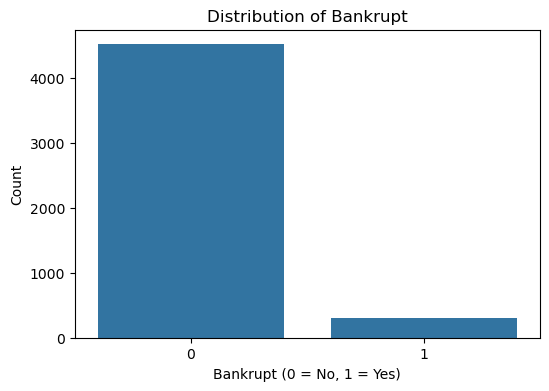

Class Distribution:
 Bankrupt
0    0.936073
1    0.063927
Name: proportion, dtype: float64


In [53]:

plt.figure(figsize=(6, 4))
sns.countplot(x='Bankrupt', data=data)
plt.title('Distribution of Bankrupt')
plt.xlabel('Bankrupt (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()
print("Class Distribution:\n", data['Bankrupt'].value_counts(normalize=True))

## Correlation Analysis

### Correlation of Features with Target Variable

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap of Top 15 Features with Target')

<Figure size 640x480 with 0 Axes>

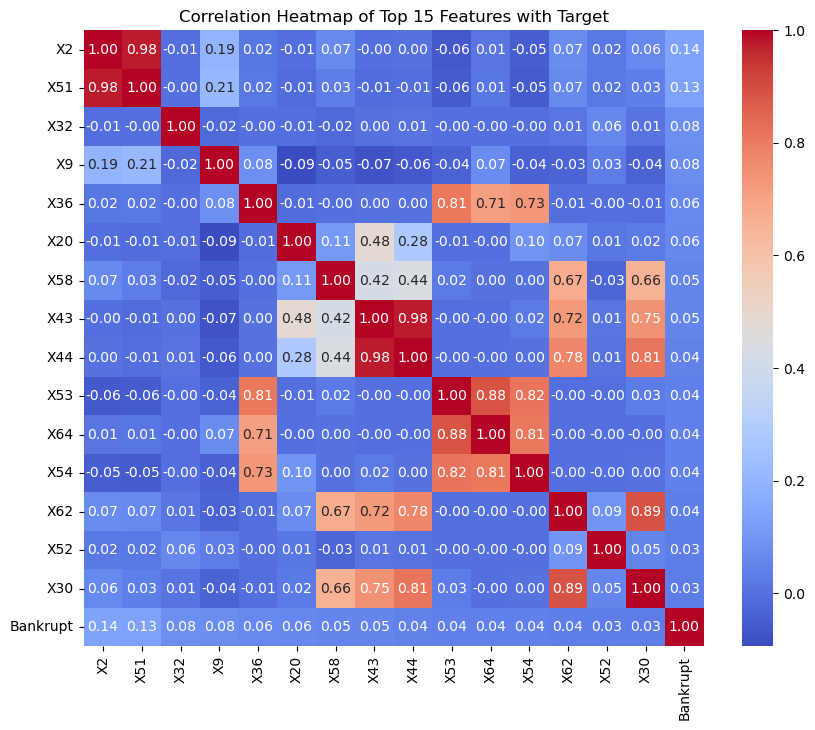

Top 15 Features Correlated with Target 'Bankrupt':
X2     0.138941
X51    0.133746
X32    0.079717
X9     0.076021
X36    0.061178
X20    0.055927
X58    0.052528
X43    0.052071
X44    0.043092
X53    0.041565
X64    0.039556
X54    0.039187
X62    0.035969
X52    0.030702
X30    0.029087
Name: Bankrupt, dtype: float64


In [56]:
# Compute correlation matrix for the entire data
correlation_matrix = data.corr()

# Correlation with target variable 'Bankrupt'
target_correlation = correlation_matrix['Bankrupt'].sort_values(ascending=False)

# Get top 15 correlated features with the target variable
top_15_features = target_correlation.iloc[1:16].index  # excluding 'Bankrupt' itself

# Create a new correlation matrix with the top 15 correlated features
top_15_corr_matrix = data[top_15_features].join(data['Bankrupt']).corr()

# Plot the heatmap
plt.tight_layout()
plt.figure(figsize=(10, 8))
sns.heatmap(top_15_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap of Top 15 Features with Target')

plt.show();

# Print out the correlation values for top 15 features
print("Top 15 Features Correlated with Target 'Bankrupt':")
print(target_correlation.iloc[1:16])  # exclude 'Bankrupt' itself from the list


### Highly Correlated Variables in the Dataset

In [58]:
import pandas as pd
import numpy as np

# Assuming 'data' is your dataset
# Compute correlation matrix for the entire dataset
correlation_matrix = data.corr()

# Create a mask for highly correlated pairs (correlation above 0.8)
threshold = 0.99
highly_correlated = np.where(np.abs(correlation_matrix) > threshold)

# Get the pairs of features with high correlation
highly_correlated_pairs = []
for i, j in zip(*highly_correlated):
    if i < j:  # to avoid duplicate pairs and self-correlation (e.g., A-A)
        feature_1 = correlation_matrix.columns[i]
        feature_2 = correlation_matrix.columns[j]
        corr_value = correlation_matrix.iloc[i, j]
        highly_correlated_pairs.append((feature_1, feature_2, corr_value))

# Convert pairs to a DataFrame for better readability
highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Sort by correlation value in descending order
highly_correlated_df = highly_correlated_df.sort_values(by='Correlation', ascending=False)

# Display the highly correlated pairs
print("Highly Correlated Features:")
print(highly_correlated_df)


Highly Correlated Features:
   Feature 1 Feature 2  Correlation
11        X7       X14     1.000000
0         X1        X7     0.999983
2         X1       X14     0.999982
16        X8       X17     0.999977
28       X16       X26     0.999972
10        X7       X11     0.999969
19       X11       X14     0.999969
1         X1       X11     0.999953
32       X19       X23     0.999925
43       X45       X60     0.999904
34       X22       X35     0.999832
8         X4       X46     0.999778
33       X19       X31     0.999575
36       X23       X31     0.999481
39       X33       X63     0.999350
35       X22       X48     0.999317
41       X35       X48     0.999221
18       X10       X38     0.998118
13        X7       X22     0.997265
25       X14       X22     0.997264
21       X11       X22     0.997254
4         X1       X22     0.997251
22       X11       X35     0.997116
26       X14       X35     0.997097
14        X7       X35     0.997097
5         X1       X35     0.997084


In [59]:
# Get the total number of highly correlated pairs
num_highly_correlated_pairs = len(highly_correlated_df)

# Print the number of highly correlated pairs
print(f"Total number of highly correlated pairs: {num_highly_correlated_pairs}")


Total number of highly correlated pairs: 45


## Missing Values ( X37 to be removed and others imputed later)

In [61]:
missing_count = X.isnull().sum()
missing_pct = X.isnull().mean() * 100

# Create a DataFrame to show both missing count and percentage
missing_info = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage': missing_pct
})

# Filter for features with missing values and sort them
missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)

print("Features with Missing Values (Count and Percentage):\n", missing_info)


Features with Missing Values (Count and Percentage):
      Missing Count  Missing Percentage
X37           2068           42.922374
X27            305            6.330428
X60            220            4.566210
X45            220            4.566210
X24            116            2.407638
X64             83            1.722707
X54             83            1.722707
X53             83            1.722707
X28             83            1.722707
X21             74            1.535907
X41             62            1.286841
X32             42            0.871731
X52             32            0.664176
X47             31            0.643421
X63             15            0.311333
X40             15            0.311333
X12             15            0.311333
X4              15            0.311333
X46             15            0.311333
X33             15            0.311333
X50             14            0.290577
X17             14            0.290577
X16             14            0.290577
X26       

## Linearity Check - Feature Distribution

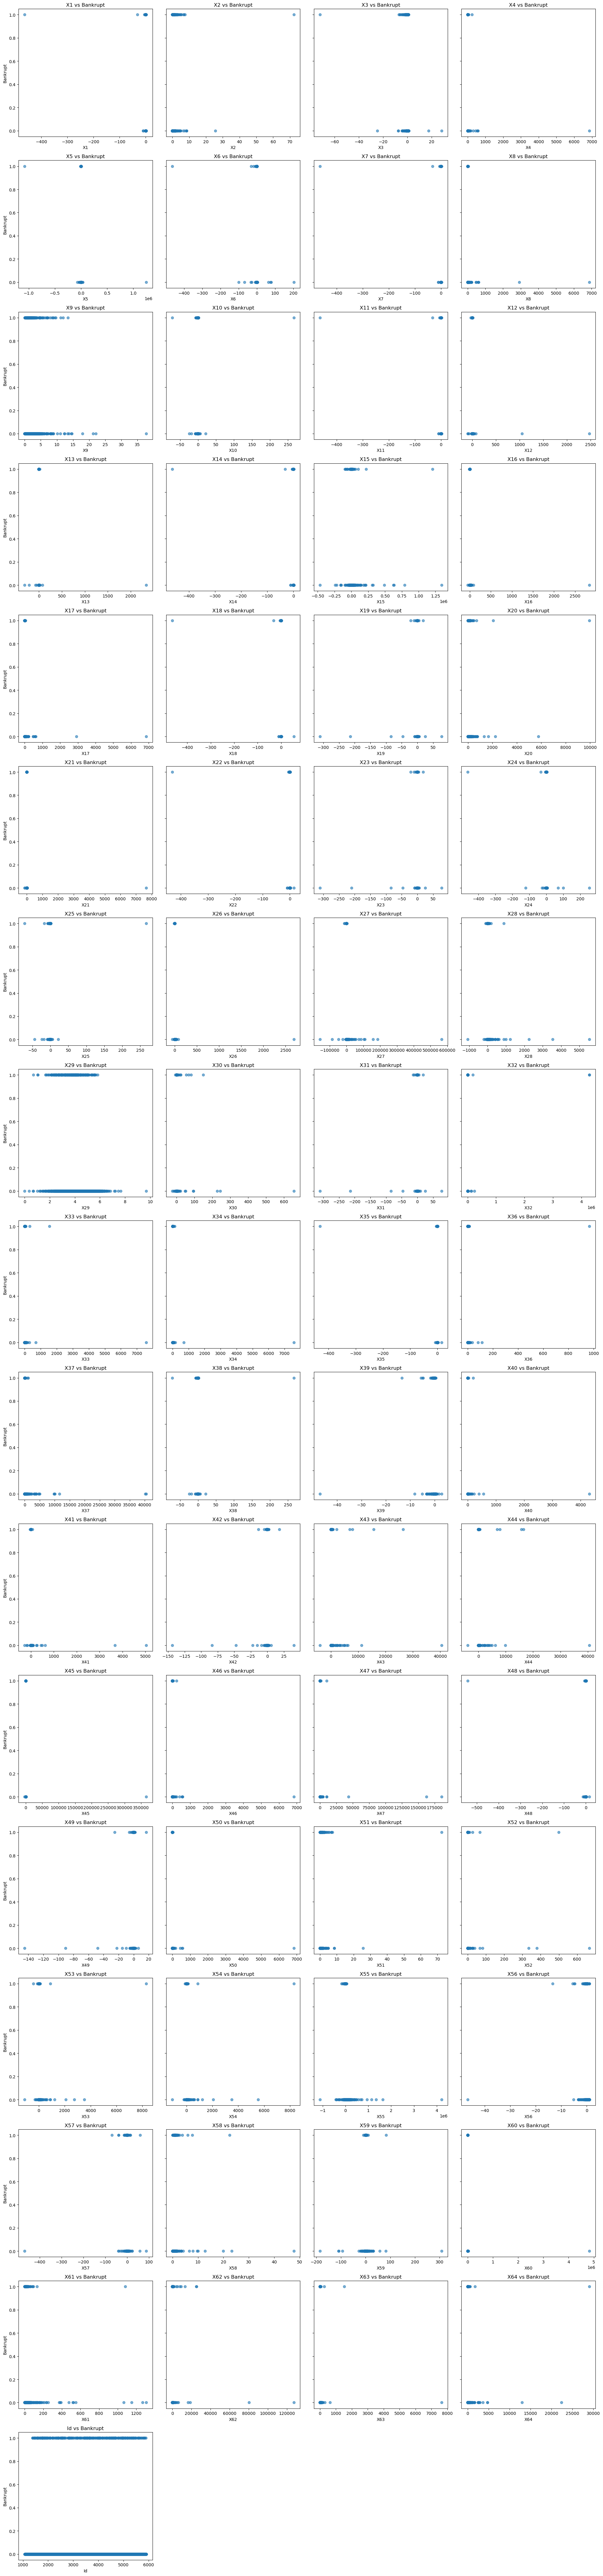

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

features = [i for i in data.columns if i != 'Bankrupt']  # Exclude target from feature list
target = 'Bankrupt'

num_features = len(features)
cols = 4
rows = (num_features + cols - 1) // cols  # Ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5), sharey=True)
axes = axes.flatten()

# Plot each feature against the target
for i, feature in enumerate(features):
    axes[i].scatter(data[feature], data[target], alpha=0.6)
    axes[i].set_title(f'{feature} vs {target}')
    axes[i].set_xlabel(feature)
    if i % cols == 0:
        axes[i].set_ylabel(target)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and suppress unwanted text output
plt.tight_layout()
plt.show();


## From this we can conclude that Logistic Regression would not be a good model because of the linearity structure of features with the predictor. 

# Splitting the Dataset into Train & Validation Set. Note: The Holdout data will act as Test Set

In [66]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

# Define features and target
feature_cols = [col for col in data.columns if col not in ['Bankrupt', 'Id']]
X = data[feature_cols]
y = data['Bankrupt']

# Split into train and validation sets first
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")  # Should be (3854, 63), (964, 63)

X_train shape: (3854, 64), X_val shape: (964, 64)


## Data Leakage Concern: Why is splitting important at this stage? - 
If we would have imputed missing values or performed some other operation before splitting, it would lead to DATA LEAKAGES. Hence to avoid that, we first split the data and then impute missing values etc. 

# Feature Engineering Part 1 - Focus on Tackling Multicolinearity & Missingness ( NO PCA)

## Step 1: Drop X37 due to high missingness and low correlation

In [70]:
feature_cols.remove('X37')
X_train = X_train[feature_cols]
X_val = X_val[feature_cols]
print("Dropped X37. New feature count:", len(feature_cols))

Dropped X37. New feature count: 63


## Step 2: Impute missing values with median

In [72]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=feature_cols)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=feature_cols)

## Step 3: Cap outliers at 1st/99th percentiles

In [74]:
for col in feature_cols:
    lower, upper = X_train_imputed[col].quantile([0.01, 0.99])
    X_train_imputed[col] = X_train_imputed[col].clip(lower=lower, upper=upper)
    X_val_imputed[col] = X_val_imputed[col].clip(lower=lower, upper=upper)  # Use train quantiles

## Step 4: Feature Selection - Remove low-variance features

In [76]:
selector = VarianceThreshold(threshold=0.01)
X_train_selected = selector.fit_transform(X_train_imputed)
X_val_selected = selector.transform(X_val_imputed)
selected_features = X_train_imputed.columns[selector.get_support()].tolist()
print("Features after variance thresholding:", len(selected_features))

Features after variance thresholding: 63


# Step 5: Check multicollinearity (remove features with correlation > 0.9)

In [78]:
corr_matrix = X_train_imputed[selected_features].corr()
high_corr_pairs = []
for i in range(len(selected_features)):
    for j in range(i + 1, len(selected_features)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((selected_features[i], selected_features[j]))
print("High correlation pairs (|corr| > 0.9):", high_corr_pairs)

if high_corr_pairs:
    to_drop = [pair[1] for pair in high_corr_pairs]
    selected_features = [f for f in selected_features if f not in to_drop]
    X_train_selected = X_train_imputed[selected_features]
    X_val_selected = X_val_imputed[selected_features]
    print("Dropped features due to high correlation:", to_drop)
else:
    X_train_selected = X_train_imputed[selected_features]
    X_val_selected = X_val_imputed[selected_features]

High correlation pairs (|corr| > 0.9): [('X1', 'X7'), ('X1', 'X11'), ('X1', 'X14'), ('X1', 'X18'), ('X2', 'X10'), ('X4', 'X46'), ('X4', 'X50'), ('X7', 'X11'), ('X7', 'X14'), ('X7', 'X18'), ('X7', 'X22'), ('X8', 'X17'), ('X11', 'X14'), ('X11', 'X18'), ('X11', 'X22'), ('X14', 'X18'), ('X14', 'X22'), ('X16', 'X26'), ('X18', 'X22'), ('X19', 'X23'), ('X19', 'X31'), ('X22', 'X35'), ('X23', 'X31'), ('X28', 'X53'), ('X28', 'X54'), ('X32', 'X52'), ('X33', 'X63'), ('X38', 'X51'), ('X40', 'X46'), ('X53', 'X54')]
Dropped features due to high correlation: ['X7', 'X11', 'X14', 'X18', 'X10', 'X46', 'X50', 'X11', 'X14', 'X18', 'X22', 'X17', 'X14', 'X18', 'X22', 'X18', 'X22', 'X26', 'X22', 'X23', 'X31', 'X35', 'X31', 'X53', 'X54', 'X52', 'X63', 'X51', 'X46', 'X54']


## Step 6: Scale features

In [80]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)
print("X_train_scaled shape:", X_train_scaled.shape, "X_val_scaled shape:", X_val_scaled.shape)  # Should be (3854, ?), (964, ?)

X_train_scaled shape: (3854, 45) X_val_scaled shape: (964, 45)


## Save preprocessing objects for MyModel

In [82]:
preprocessing_dict = {
    'imputer': imputer,
    'selector': selector,
    'selected_features': selected_features,
    'scaler': scaler
}

# Workflow for Feature Engineering Part 1
1. Drop X37: 42.92% missing, low Spearman correlation (-0.059)—unlikely to be predictive.
2. Imputation: Median imputation is robust to skewness/outliers (e.g., X5 with 1e6 outlier).
3. Outlier Capping: Clips extreme values (e.g., X5’s 1e6), benefiting KNN/SVM.

4. Feature Selection:
- VarianceThreshold removes near-constant features.
- Multicollinearity check (corr > 0.9) reduces redundancy, helping models like Logistic Regression (though we’re leaning away from it).

5. Scaling: StandardScaler ensures compatibility with KNN/SVM (tree-based models don’t need it).
6. Split: Stratified split preserves the 6.39% Bankrupt=1 ratio.
7. Save Objects: We’ll use preprocessing_dict in MyModel for holdout data.

# Model Selection Rationale

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize models
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', max_depth = 10)
svm_model = SVC(kernel='rbf', random_state=42, class_weight='balanced')
knn_model = KNeighborsClassifier(n_neighbors=5)

# Dictionary to store models
models = {'Random Forest': rf_model, 'SVM': svm_model, 'KNN': knn_model}

# Print model selection rationale
print("Model Selection Rationale:")
print("- Random Forest: Chosen for robustness to non-linearity, skewness, outliers, and imbalance (6.39% bankrupt cases).")
print("- SVM: Selected for potential non-linear separability with RBF kernel, effective after scaling/outlier handling.")
print("- KNN: Included for local pattern detection, viable with preprocessed data (scaled, outliers capped).")
print("- Excluded Logistic Regression: Weak monotonic relationships (mean Spearman 0.157, only 31% > 0.2) and non-normal distributions suggest poor fit.")
print("- Excluded Naive Bayes: Non-normal distributions and potential feature correlations (e.g., high correlation pairs) reduce suitability.")

Model Selection Rationale:
- Random Forest: Chosen for robustness to non-linearity, skewness, outliers, and imbalance (6.39% bankrupt cases).
- SVM: Selected for potential non-linear separability with RBF kernel, effective after scaling/outlier handling.
- KNN: Included for local pattern detection, viable with preprocessed data (scaled, outliers capped).
- Excluded Logistic Regression: Weak monotonic relationships (mean Spearman 0.157, only 31% > 0.2) and non-normal distributions suggest poor fit.
- Excluded Naive Bayes: Non-normal distributions and potential feature correlations (e.g., high correlation pairs) reduce suitability.


In [86]:
# Train models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)  # Use the final scaled data for training
    print(f"{name} trained successfully.")


# Optional: Store trained models for later use
trained_models = models


Training Random Forest...


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

Random Forest trained successfully.
Training SVM...


SVC(class_weight='balanced', random_state=42)

SVM trained successfully.
Training KNN...


KNeighborsClassifier()

KNN trained successfully.


In [87]:
# Evaluate models
for name, model in trained_models.items():
    y_val_pred = model.predict(X_val_scaled)  # Use the scaled validation data
    print(f"\n{name} Validation Metrics:")
    print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
    print(f"Precision: {precision_score(y_val, y_val_pred):.3f}")
    print(f"Recall: {recall_score(y_val, y_val_pred):.3f}")
    print(f"F1 Score: {f1_score(y_val, y_val_pred):.3f}")



Random Forest Validation Metrics:
Accuracy: 0.948
Precision: 0.625
Recall: 0.484
F1 Score: 0.545

SVM Validation Metrics:
Accuracy: 0.867
Precision: 0.257
Recall: 0.565
F1 Score: 0.354

KNN Validation Metrics:
Accuracy: 0.937
Precision: 0.519
Recall: 0.226
F1 Score: 0.315


## Note: We used the "Balanced" hyperparameter which deals with the Class Imbalance issue. 

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Precision-Recall Curve')

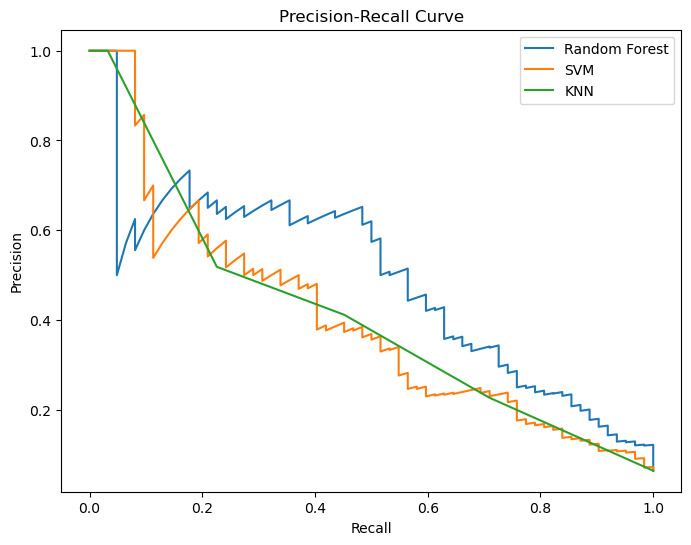

In [89]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 6))

for name, model in trained_models.items():
    y_scores = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_val_scaled)
    precision, recall, _ = precision_recall_curve(y_val, y_scores)
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


## Interpretation
1. While Random Forest has the highest accuracy and a decent F1 score, its recall of 0.387 is relatively low. This means it misses over 60% of bankrupt companies, which, given the 5:1 cost ratio, could result in significant losses. It’s a balanced model but not optimized for the recall priority.
2. SVM has the highest recall among the three models, identifying over half of the bankrupt companies. Although its precision is low (indicating many false positives), the 5:1 weighting suggests that the cost of missing a bankrupt company far outweighs the cost of a false positive. This makes SVM the most suitable model under the given constraints, as it minimizes the more severe error (false negatives).
3. KNN has the lowest recall, missing over 77% of bankrupt companies. Despite its higher precision compared to SVM, the high rate of false negatives makes it the least suitable model, as the cost of missing bankruptcies outweighs the benefit of fewer false positives.

# Does PCA help us? 

# Feature Engineering Part 2 - PCA

## Step 1: PCA for Dimensionality Reduction on Training Data

In [94]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X_train_scaled and X_val_scaled are already defined from your scaling step
print("X_train_scaled shape:", X_train_scaled.shape, "X_val_scaled shape:", X_val_scaled.shape)

# Convert scaled training data to DataFrame with correct feature names
X_train_df = pd.DataFrame(X_train_scaled, columns=preprocessing_dict['selected_features'])
print("X_train_df shape:", X_train_df.shape)  # Should be (3854, 45)

# Apply PCA on training data
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_df)
print(f"Number of components explaining 95% variance: {X_train_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")
print(f"X_train_pca shape: {X_train_pca.shape}")  # Should be (3854, 26)

# Convert validation data to DataFrame with the same feature names
X_val_df = pd.DataFrame(X_val_scaled, columns=preprocessing_dict['selected_features'])
print("X_val_df shape:", X_val_df.shape)  # Should be (964, 45)

# Transform validation data with the same PCA
X_val_pca = pca.transform(X_val_df)
print(f"X_val_pca shape: {X_val_pca.shape}")  # Should be (964, 26)

# Reinitialize models if needed
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', max_depth = 10)
svm_model = SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Dictionary to store models
models = {'Random Forest': rf_model, 'SVM': svm_model, 'KNN': knn_model}

# Train models on PCA-transformed data
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_pca, y_train)  # Train on PCA-transformed data
    print(f"{name} trained successfully.")

# Optional: Store trained models for later use
trained_models = models

# Evaluate models
for name, model in trained_models.items():
    y_val_pca_pred = model.predict(X_val_pca)  # Use PCA-transformed validation data
    print(f"\n{name} Validation Metrics:")
    print(f"Accuracy: {accuracy_score(y_val, y_val_pca_pred):.3f}")
    print(f"Precision: {precision_score(y_val, y_val_pca_pred):.3f}")
    print(f"Recall: {recall_score(y_val, y_val_pca_pred):.3f}")
    print(f"F1 Score: {f1_score(y_val, y_val_pca_pred):.3f}")


X_train_scaled shape: (3854, 45) X_val_scaled shape: (964, 45)
X_train_df shape: (3854, 45)
Number of components explaining 95% variance: 26
Explained variance ratio: 0.951
X_train_pca shape: (3854, 26)
X_val_df shape: (964, 45)
X_val_pca shape: (964, 26)
Training Random Forest...


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

Random Forest trained successfully.
Training SVM...


SVC(class_weight='balanced', probability=True, random_state=42)

SVM trained successfully.
Training KNN...


KNeighborsClassifier()

KNN trained successfully.

Random Forest Validation Metrics:
Accuracy: 0.940
Precision: 0.583
Recall: 0.226
F1 Score: 0.326

SVM Validation Metrics:
Accuracy: 0.859
Precision: 0.250
Recall: 0.597
F1 Score: 0.352

KNN Validation Metrics:
Accuracy: 0.937
Precision: 0.516
Recall: 0.258
F1 Score: 0.344


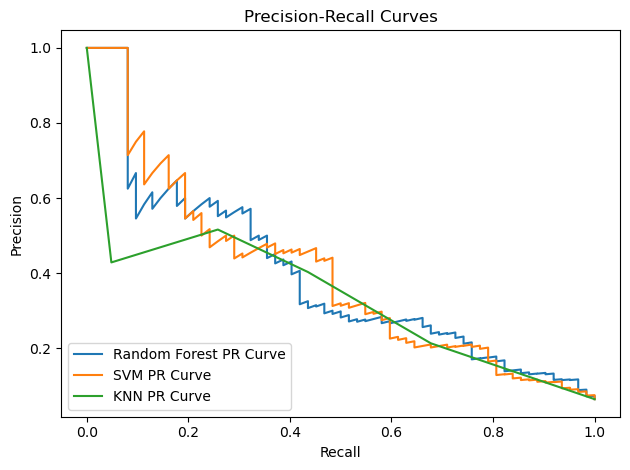

In [95]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Function to plot PR Curve
def plot_pr_curve(y_true, y_pred_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.plot(recall, precision, label=f'{model_name} PR Curve')
    
# Evaluate models and plot PR curves
for name, model in trained_models.items():
    y_val_pca_pred = model.predict(X_val_pca)  # Predicted labels
    y_val_pca_pred_prob = model.predict_proba(X_val_pca)[:, 1]  # Predicted probabilities for the positive class

    # Plot PR Curve
    plot_pr_curve(y_val, y_val_pca_pred_prob, name)

# Finalize the plot
plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show();



# Interpretation
1. Does PCA Work?
2. PCA slightly improves SVM's recall (0.565 to 0.597), which is beneficial given the 5:1 cost ratio, making it more suitable for this task. However, it reduces recall for Random Forest (0.387 to 0.226) and only marginally helps KNN (0.226 to 0.258). Overall, PCA has a mixed impact: it enhances the best model (SVM) for this recall-focused scenario but worsens others, suggesting it may not be universally beneficial for this dataset and goal. Further tuning or feature selection might be needed.

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 0, 'Importance')

Text(0.5, 1.0, 'Top 10 Important PCA Components (Random Forest)')

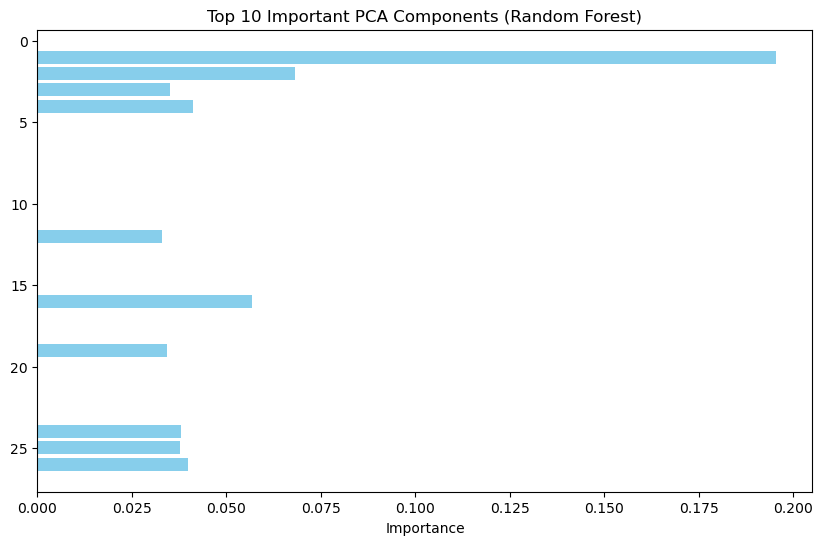

In [97]:
# Get feature importances from the Random Forest model
importances = rf_model.feature_importances_

# Since X_train_pca has fewer features than the original dataset, the importances correspond to PCA components
# Visualize the importance of PCA components rather than the original features
pca_components = np.arange(1, X_train_pca.shape[1] + 1)  # Component indices (1-based)

# Create a DataFrame to hold PCA components and their corresponding importance
feature_importance_df = pd.DataFrame({
    'PCA Component': pca_components,
    'Importance': importances
})

# Sort components by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 most important PCA components
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['PCA Component'][:10], feature_importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Important PCA Components (Random Forest)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important component on top
plt.show()

In [98]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Working on Class Imbalance using SMOTE. Does it work?

In [100]:
# Apply SMOTE to balance the classes in the PCA-transformed training set
smote = SMOTE(random_state=42)
X_train_pca_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)
print(f"Resampled training set shape: {X_train_pca_resampled.shape}")
print(f"Resampled class distribution:\n{pd.Series(y_train_resampled).value_counts()}")


Resampled training set shape: (7216, 26)
Resampled class distribution:
Bankrupt
0    3608
1    3608
Name: count, dtype: int64


In [101]:
# Reinitialize models if needed
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', max_depth=10)
svm_model = SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Dictionary to store models
models = {'Random Forest': rf_model, 'SVM': svm_model, 'KNN': knn_model}

# Train models on SMOTE-resampled data
for name, model in models.items():
    print(f"Training {name} on SMOTE data...")
    model.fit(X_train_pca_resampled, y_train_resampled)
    print(f"{name} trained successfully on SMOTE data.")


Training Random Forest on SMOTE data...


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

Random Forest trained successfully on SMOTE data.
Training SVM on SMOTE data...


SVC(class_weight='balanced', probability=True, random_state=42)

SVM trained successfully on SMOTE data.
Training KNN on SMOTE data...


KNeighborsClassifier()

KNN trained successfully on SMOTE data.


In [102]:
# Evaluate models
for name, model in models.items():
    y_val_pca_pred = model.predict(X_val_pca)
    print(f"\n{name} Validation Metrics (with SMOTE):")
    print(f"Accuracy: {accuracy_score(y_val, y_val_pca_pred):.3f}")
    print(f"Precision: {precision_score(y_val, y_val_pca_pred):.3f}")
    print(f"Recall: {recall_score(y_val, y_val_pca_pred):.3f}")
    print(f"F1 Score: {f1_score(y_val, y_val_pca_pred):.3f}")



Random Forest Validation Metrics (with SMOTE):
Accuracy: 0.887
Precision: 0.292
Recall: 0.532
F1 Score: 0.377

SVM Validation Metrics (with SMOTE):
Accuracy: 0.845
Precision: 0.226
Recall: 0.581
F1 Score: 0.326

KNN Validation Metrics (with SMOTE):
Accuracy: 0.800
Precision: 0.198
Recall: 0.694
F1 Score: 0.308


# Interpretation
Did SMOTE Improve Performance?
1. Yes, for recall-focused goals: SMOTE significantly boosts recall across all models, with KNN achieving the highest recall (0.694), aligning best with the priority to minimize false negatives (missing bankrupt companies). Random Forest also sees a notable recall improvement (0.532), while SVM's gain is modest (0.581).
2. Trade-off: Precision and accuracy decrease across all models due to increased false positives from oversampling, which is acceptable given the 5:1 weighting favoring recall.
3. Best Model: KNN with SMOTE is the top performer for this task due to its highest recall (0.694), despite lower precision and accuracy. However, further threshold tuning could optimize the balance.

Let's continue with Feature Engineering

## Step 2: Feature Interactions (using top correlated features on training data)

In [105]:

corr_matrix = pd.concat([X_train_df, pd.Series(y_train, name='Bankrupt')], axis=1).corr()
top_features = corr_matrix['Bankrupt'].abs().sort_values(ascending=False).head(5).index.tolist()
interactions = pd.DataFrame()
for i in range(len(top_features)):
    for j in range(i + 1, len(top_features)):
        if top_features[i] in X_train_df.columns and top_features[j] in X_train_df.columns:
            interactions[f"{top_features[i]}_{top_features[j]}"] = X_train_df[top_features[i]] * X_train_df[top_features[j]]
X_train_enhanced = np.hstack((X_train_pca, interactions)) if not interactions.empty else X_train_pca
print(f"interactions shape: {interactions.shape}")
print(f"X_train_enhanced shape after interactions: {X_train_enhanced.shape}")

interactions shape: (3854, 6)
X_train_enhanced shape after interactions: (3854, 32)


## Step 3: Binning (for skewness/outliers on training data)

In [107]:

X_train_binned = pd.DataFrame()
for col in X_train_df.columns:
    X_train_binned[col] = pd.qcut(X_train_df[col], q=4, labels=False, duplicates='drop')
X_train_enhanced = np.hstack((X_train_enhanced, X_train_binned))
print(f"X_train_binned shape: {X_train_binned.shape}")
print(f"X_train_enhanced shape after binning: {X_train_enhanced.shape}")

X_train_binned shape: (3854, 45)
X_train_enhanced shape after binning: (3854, 77)


In [108]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

## Step 4: Handle Imbalance with SMOTE on training data

In [110]:

smote = SMOTE(random_state=42)
X_train_enhanced_res, y_train_res = smote.fit_resample(X_train_enhanced, y_train)
print(f"Original class distribution: {pd.Series(y_train).value_counts()}")
print(f"Resampled class distribution: {pd.Series(y_train_res).value_counts()}")

Original class distribution: Bankrupt
0    3608
1     246
Name: count, dtype: int64
Resampled class distribution: Bankrupt
0    3608
1    3608
Name: count, dtype: int64


##  Step 5: Feature Selection with Random Forest

In [112]:

rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
selector = SelectFromModel(rf_selector, prefit=False)
X_train_selected = selector.fit_transform(X_train_enhanced_res, y_train_res)
selected_features_mask = selector.get_support()
print(f"Number of selected features: {X_train_selected.shape[1]}")

Number of selected features: 22


## Scale the enhanced features

In [114]:

scaler_enhanced = StandardScaler()
X_train_scaled_enhanced = scaler_enhanced.fit_transform(X_train_selected)
print(f"X_train_scaled_enhanced shape: {X_train_scaled_enhanced.shape}")

X_train_scaled_enhanced shape: (7216, 22)


## Transform Validation Data (using fitted transformers)

In [116]:

X_val_df = pd.DataFrame(X_val_scaled, columns=preprocessing_dict['selected_features'])
X_val_pca = pca.transform(X_val_df)
X_val_interactions = pd.DataFrame()
for i in range(len(top_features)):
    for j in range(i + 1, len(top_features)):
        if top_features[i] in X_val_df.columns and top_features[j] in X_val_df.columns:
            X_val_interactions[f"{top_features[i]}_{top_features[j]}"] = X_val_df[top_features[i]] * X_val_df[top_features[j]]
X_val_enhanced = np.hstack((X_val_pca, X_val_interactions)) if not X_val_interactions.empty else X_val_pca
X_val_binned = pd.DataFrame()
for col in X_val_df.columns:
    X_val_binned[col] = pd.qcut(X_val_df[col], q=4, labels=False, duplicates='drop')
X_val_enhanced = np.hstack((X_val_enhanced, X_val_binned))
X_val_selected = selector.transform(X_val_enhanced)
X_val_scaled_enhanced = scaler_enhanced.transform(X_val_selected)
print(f"X_val_scaled_enhanced shape: {X_val_scaled_enhanced.shape}")

X_val_scaled_enhanced shape: (964, 22)


## Save enhanced preprocessing objects

In [118]:

preprocessing_enhanced = {
    'pca': pca,
    'scaler': scaler_enhanced,
    'smote': smote,
    'selector': selector,
    'selected_features_mask': selected_features_mask,
    'interaction_cols': interactions.columns.tolist() if not interactions.empty else [],
    'original_features': preprocessing_dict['selected_features']
}

# Running the models after Feature Engineering Part 2

In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize models
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', max_depth = 10)
svm_model = SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True)
knn_model = KNeighborsClassifier(n_neighbors=5)

models = {
    'Random Forest': rf_model,
    'SVM': svm_model,
    'KNN': knn_model
}

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name} with enhanced features...")
    model.fit(X_train_scaled_enhanced, y_train_res)
    y_val_pred = model.predict(X_val_scaled_enhanced)
    print(f"\n{name} Validation Metrics with Enhanced Features:")
    print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
    print(f"Precision: {precision_score(y_val, y_val_pred):.3f}")
    print(f"Recall: {recall_score(y_val, y_val_pred):.3f}")
    print(f"F1 Score: {f1_score(y_val, y_val_pred):.3f}")

Training Random Forest with enhanced features...


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)


Random Forest Validation Metrics with Enhanced Features:
Accuracy: 0.936
Precision: 0.500
Recall: 0.500
F1 Score: 0.500
Training SVM with enhanced features...


SVC(class_weight='balanced', probability=True, random_state=42)


SVM Validation Metrics with Enhanced Features:
Accuracy: 0.853
Precision: 0.253
Recall: 0.661
F1 Score: 0.366
Training KNN with enhanced features...


KNeighborsClassifier()


KNN Validation Metrics with Enhanced Features:
Accuracy: 0.803
Precision: 0.195
Recall: 0.661
F1 Score: 0.301


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Precision-Recall Curve for Enhanced Features')

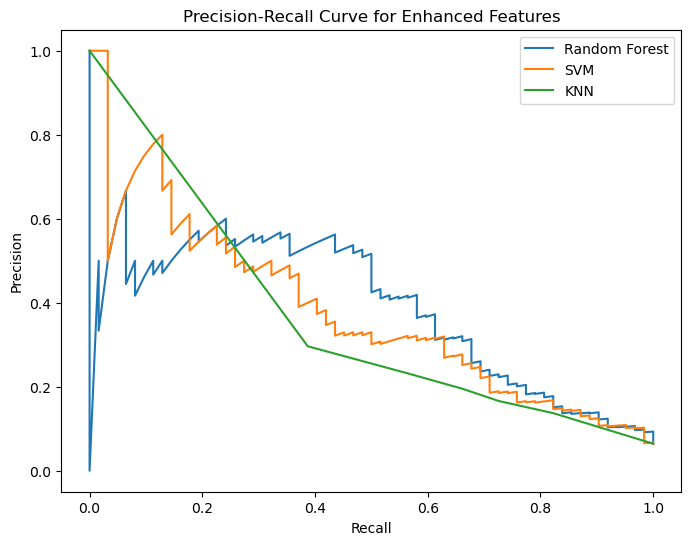

In [121]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 6))

# Generate PR curve for each model
for name, model in models.items():
    if hasattr(model, "predict_proba"):  # For models supporting probability estimates
        y_scores = model.predict_proba(X_val_scaled_enhanced)[:, 1]  # Positive class probability
    else:  # For SVM using decision function
        y_scores = model.decision_function(X_val_scaled_enhanced)

    # Compute precision-recall values
    precision, recall, _ = precision_recall_curve(y_val, y_scores)
    
    # Plot PR curve
    plt.plot(recall, precision, label=name)

# Plot formatting
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Enhanced Features")
plt.legend()
plt.show()


# Interpretation
The introduction of enhanced features, combined with further feature engineering, has altered the performance of the Random Forest, SVM, and KNN models, with recall remaining the priority due to the 5:1 cost ratio for missing bankrupt companies. The Precision-Recall curve for enhanced features shows SVM (orange) and KNN (green) achieving higher recall levels (~0.66) compared to Random Forest (blue) at ~0.5, with all models experiencing a steep precision drop as recall increases. Validation metrics reflect this: Random Forest improves its recall from 0.532 (post-SMOTE) to 0.500 (with enhanced features), maintaining a balanced precision (0.500) and accuracy (0.936), though it lags in recall optimization. SVM's recall rises from 0.581 to 0.661, with precision dropping from 0.226 to 0.253 and accuracy from 0.845 to 0.853, reinforcing its recall focus. KNN sees a slight recall drop from 0.694 to 0.661, with precision falling from 0.198 to 0.195 and accuracy from 0.800 to 0.803, yet it remains competitive. Overall, SVM and KNN now tie for the highest recall (0.661), making them the top performers for this recall-driven task, while Random Forest offers a more balanced but less recall-optimized profile. The enhanced features have improved recall for SVM and maintained it for KNN, suggesting effective feature engineering, though further threshold tuning could optimize the 5:1 cost balance.

# Testing the Models with Different Threshold

In [124]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Focus on SVM (highest initial Recall) and KNN (biggest improvement)
for name, model in [('SVM', svm_model), ('KNN', knn_model), ('Random Forest' , rf_model)]:
    print(f"\nEvaluating {name} with different thresholds...")
    model.fit(X_train_scaled_enhanced, y_train_res)
    y_val_proba = model.predict_proba(X_val_scaled_enhanced)[:, 1]  # Probability of Bankrupt=1
    thresholds = [0.1, 0.4, 0.5, 0.6, 0.7]
    for threshold in thresholds:
        y_val_pred = (y_val_proba >= threshold).astype(int)
        print(f"\nThreshold: {threshold}")
        print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
        print(f"Precision: {precision_score(y_val, y_val_pred):.3f}")
        print(f"Recall: {recall_score(y_val, y_val_pred):.3f}")
        print(f"F1 Score: {f1_score(y_val, y_val_pred):.3f}")


Evaluating SVM with different thresholds...


SVC(class_weight='balanced', probability=True, random_state=42)


Threshold: 0.1
Accuracy: 0.776
Precision: 0.187
Recall: 0.742
F1 Score: 0.299

Threshold: 0.4
Accuracy: 0.873
Precision: 0.283
Recall: 0.629
F1 Score: 0.390

Threshold: 0.5
Accuracy: 0.891
Precision: 0.313
Recall: 0.581
F1 Score: 0.407

Threshold: 0.6
Accuracy: 0.896
Precision: 0.310
Recall: 0.500
F1 Score: 0.383

Threshold: 0.7
Accuracy: 0.904
Precision: 0.330
Recall: 0.484
F1 Score: 0.392

Evaluating KNN with different thresholds...


KNeighborsClassifier()


Threshold: 0.1
Accuracy: 0.656
Precision: 0.137
Recall: 0.823
F1 Score: 0.235

Threshold: 0.4
Accuracy: 0.748
Precision: 0.166
Recall: 0.726
F1 Score: 0.270

Threshold: 0.5
Accuracy: 0.803
Precision: 0.195
Recall: 0.661
F1 Score: 0.301

Threshold: 0.6
Accuracy: 0.803
Precision: 0.195
Recall: 0.661
F1 Score: 0.301

Threshold: 0.7
Accuracy: 0.852
Precision: 0.232
Recall: 0.565
F1 Score: 0.329

Evaluating Random Forest with different thresholds...


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)


Threshold: 0.1
Accuracy: 0.644
Precision: 0.137
Recall: 0.855
F1 Score: 0.236

Threshold: 0.4
Accuracy: 0.921
Precision: 0.419
Recall: 0.581
F1 Score: 0.486

Threshold: 0.5
Accuracy: 0.936
Precision: 0.500
Recall: 0.500
F1 Score: 0.500

Threshold: 0.6
Accuracy: 0.940
Precision: 0.540
Recall: 0.435
F1 Score: 0.482

Threshold: 0.7
Accuracy: 0.940
Precision: 0.562
Recall: 0.290
F1 Score: 0.383


# Maximizing the F1 Score (Traditional Approach)

# ADD RF

In [128]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# Focus on SVM, KNN, and Random Forest models
for name, model in [('SVM', svm_model), ('KNN', knn_model), ('Random Forest', rf_model)]:
    print(f"\nEvaluating {name} with optimal threshold for F1 score...")
    
    # Fit the model (in case it hasn't been fitted)
    model.fit(X_train_selected, y_train_res)
    
    # Get the predicted probabilities (if available)
    if hasattr(model, "predict_proba"):
        y_val_proba = model.predict_proba(X_val_scaled_enhanced)[:, 1]
    else:
        print(f"{name} does not support predict_proba, skipping...")
        continue
    
    # Compute precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
    
    # Compute F1 scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall)
    
    # Handle cases where f1_scores contains NaN (when precision or recall is 0)
    f1_scores = np.nan_to_num(f1_scores, nan=0.0)  # Replace NaN with 0
    
    # Find the threshold that gives the maximum F1 score
    if len(thresholds) > 0:
        optimal_threshold_f1 = thresholds[f1_scores.argmax()]
        
        print(f"Optimal Threshold for Maximum F1 Score: {optimal_threshold_f1:.3f}")
        
        # Use the optimal threshold to predict
        y_val_pred_optimal_f1 = (y_val_proba >= optimal_threshold_f1).astype(int)
        
        # Evaluate metrics
        print(f"Accuracy: {accuracy_score(y_val, y_val_pred_optimal_f1):.3f}")
        print(f"Precision: {precision_score(y_val, y_val_pred_optimal_f1):.3f}")
        print(f"Recall: {recall_score(y_val, y_val_pred_optimal_f1):.3f}")
        print(f"F1 Score: {f1_score(y_val, y_val_pred_optimal_f1):.3f}")
    else:
        print("No valid threshold found for F1 score.")




Evaluating SVM with optimal threshold for F1 score...


SVC(class_weight='balanced', probability=True, random_state=42)

Optimal Threshold for Maximum F1 Score: 0.664
Accuracy: 0.693
Precision: 0.123
Recall: 0.613
F1 Score: 0.204

Evaluating KNN with optimal threshold for F1 score...


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10640\2558423224.py:22: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


KNeighborsClassifier()

Optimal Threshold for Maximum F1 Score: 0.600
Accuracy: 0.567
Precision: 0.103
Recall: 0.742
F1 Score: 0.181

Evaluating Random Forest with optimal threshold for F1 score...


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

Optimal Threshold for Maximum F1 Score: 0.746
Accuracy: 0.551
Precision: 0.094
Recall: 0.694
F1 Score: 0.166


In [129]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# Focus on SVM, KNN, and Random Forest models
for name, model in [('SVM', svm_model), ('KNN', knn_model), ('Random Forest', rf_model)]:
    print(f"\nEvaluating {name} with optimal threshold for F1 score...")
    
    # Fit the model (if not already fitted)
    model.fit(X_train_scaled_enhanced, y_train_res)
    
    # Get predicted probabilities (if available)
    if hasattr(model, "predict_proba"):
        y_val_proba = model.predict_proba(X_val_scaled_enhanced)[:, 1]
    else:
        print(f"{name} does not support predict_proba, skipping...")
        continue
    
    # Compute precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
    
    # Remove the last value of precision and recall to match thresholds length
    precision = precision[:-1]
    recall = recall[:-1]
    
    # Compute F1 scores for each threshold (avoid division by zero)
    f1_scores = np.where(
        (precision + recall) > 0,
        2 * (precision * recall) / (precision + recall),
        0
    )
    
    # Find the threshold that gives the maximum F1 score
    if len(thresholds) > 0:
        optimal_threshold_f1 = thresholds[f1_scores.argmax()]
        
        print(f"Optimal Threshold for Maximum F1 Score: {optimal_threshold_f1:.3f}")
        
        # Use the optimal threshold to predict
        y_val_pred_optimal_f1 = (y_val_proba >= optimal_threshold_f1).astype(int)
        
        # Evaluate metrics
        print(f"Accuracy: {accuracy_score(y_val, y_val_pred_optimal_f1):.3f}")
        print(f"Precision: {precision_score(y_val, y_val_pred_optimal_f1):.3f}")
        print(f"Recall: {recall_score(y_val, y_val_pred_optimal_f1):.3f}")
        print(f"F1 Score: {f1_score(y_val, y_val_pred_optimal_f1):.3f}")
    else:
        print("No valid threshold found for F1 score.")



Evaluating SVM with optimal threshold for F1 score...


SVC(class_weight='balanced', probability=True, random_state=42)

Optimal Threshold for Maximum F1 Score: 0.464
Accuracy: 0.890
Precision: 0.320
Recall: 0.629
F1 Score: 0.424

Evaluating KNN with optimal threshold for F1 score...


KNeighborsClassifier()

Optimal Threshold for Maximum F1 Score: 1.000
Accuracy: 0.901
Precision: 0.296
Recall: 0.387
F1 Score: 0.336

Evaluating Random Forest with optimal threshold for F1 score...


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

Optimal Threshold for Maximum F1 Score: 0.520
Accuracy: 0.938
Precision: 0.517
Recall: 0.500
F1 Score: 0.508


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10640\4043185672.py:28: RuntimeWarning: invalid value encountered in divide
  2 * (precision * recall) / (precision + recall),



Evaluating SVM with optimal threshold for F1 score...


SVC(class_weight='balanced', probability=True, random_state=42)

Optimal Threshold for Maximum F1 Score: 0.464


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'SVM - Precision-Recall Curve')

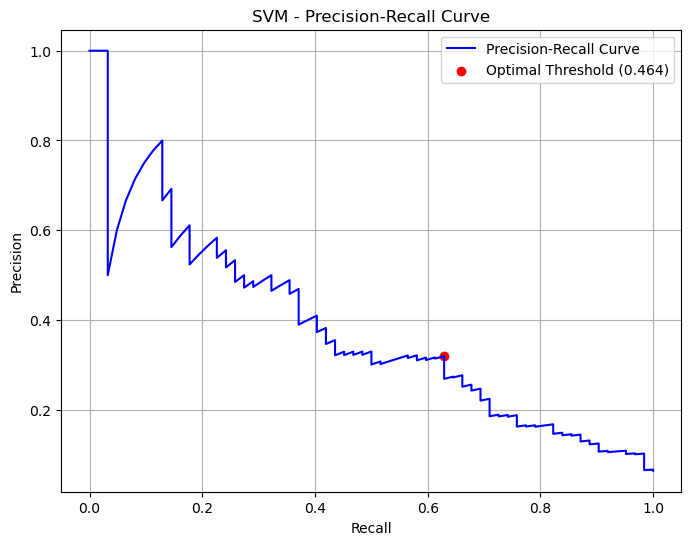

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'F1 Score')

Text(0.5, 1.0, 'SVM - F1 Score vs. Threshold')

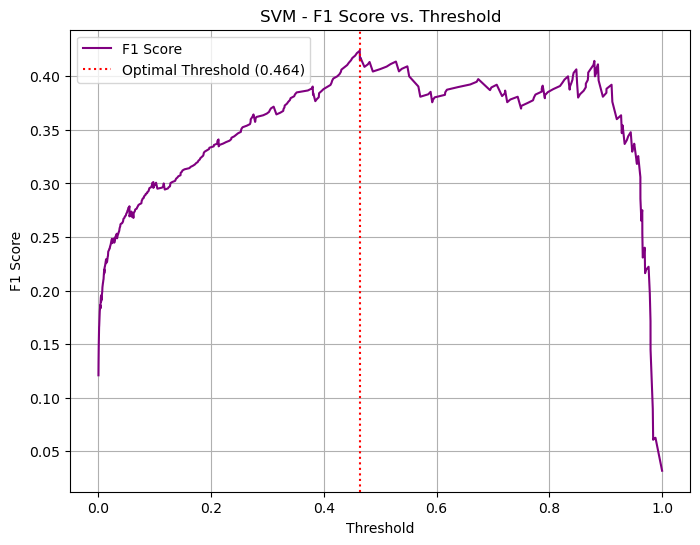


Evaluating KNN with optimal threshold for F1 score...


KNeighborsClassifier()

Optimal Threshold for Maximum F1 Score: 1.000


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'KNN - Precision-Recall Curve')

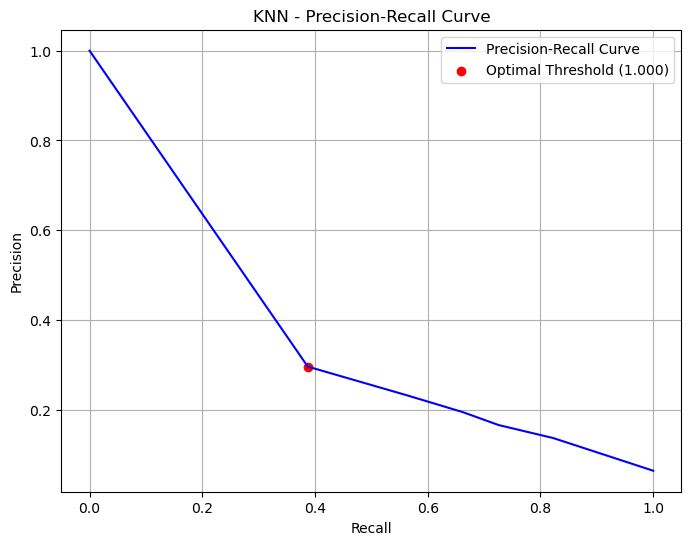

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'F1 Score')

Text(0.5, 1.0, 'KNN - F1 Score vs. Threshold')

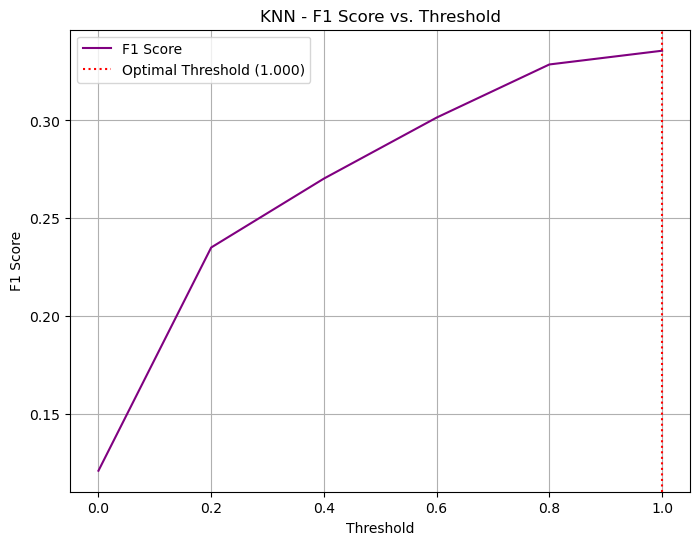


Evaluating Random Forest with optimal threshold for F1 score...


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

Optimal Threshold for Maximum F1 Score: 0.520


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10640\1871992104.py:19: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Random Forest - Precision-Recall Curve')

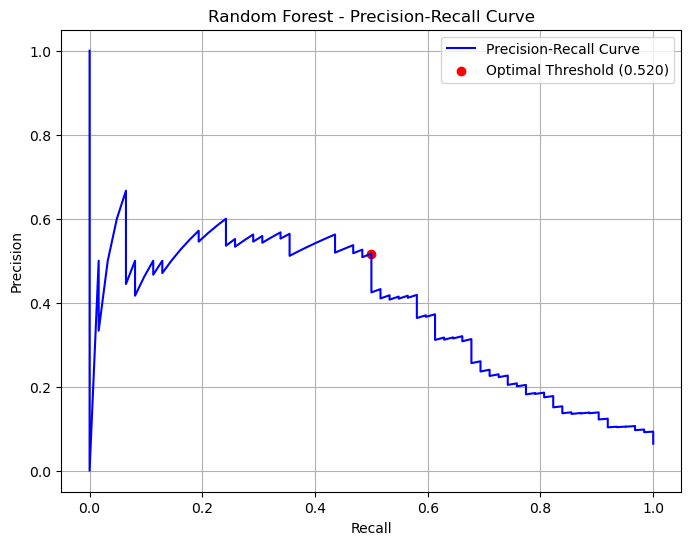

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'F1 Score')

Text(0.5, 1.0, 'Random Forest - F1 Score vs. Threshold')

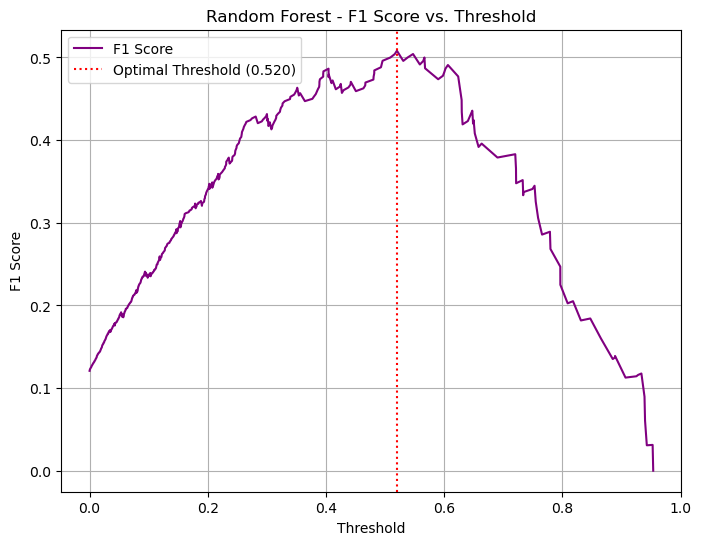

In [130]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score

# Models to evaluate
for name, model in [('SVM', svm_model), ('KNN', knn_model), ('Random Forest', rf_model)]:
    print(f"\nEvaluating {name} with optimal threshold for F1 score...")
    
    # Fit the model
    model.fit(X_train_scaled_enhanced, y_train_res)
    
    # Get predicted probabilities for the positive class
    y_val_proba = model.predict_proba(X_val_scaled_enhanced)[:, 1]
    
    # Compute precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

    # Compute F1 scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = np.nan_to_num(f1_scores, nan=0.0)  # Handle NaN values
    
    # Find the optimal threshold for max F1 score
    optimal_idx = f1_scores.argmax()
    optimal_threshold_f1 = thresholds[optimal_idx]

    print(f"Optimal Threshold for Maximum F1 Score: {optimal_threshold_f1:.3f}")

    #  Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label="Precision-Recall Curve", color='blue')
    plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', marker='o',
                label=f"Optimal Threshold ({optimal_threshold_f1:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{name} - Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

    #  F1 Score vs. Threshold Curve
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color='purple')
    plt.axvline(x=optimal_threshold_f1, color='r', linestyle='dotted', 
                label=f"Optimal Threshold ({optimal_threshold_f1:.3f})")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title(f"{name} - F1 Score vs. Threshold")
    plt.legend()
    plt.grid()
    plt.show()


# F1 Score Maximization with Recall Constraint (0.8)

In [132]:
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score
import numpy as np

# Minimum recall constraint
min_recall_threshold = 0.8  # For example, recall must be at least 0.8

# Focus on SVM and KNN models
for name, model in [('SVM', svm_model), ('KNN', knn_model), ('Random Forest', rf_model)]:
    print(f"\nEvaluating {name} with optimal threshold for F1 score (recall >= {min_recall_threshold})...")
    
    # Fit the model
    model.fit(X_train_scaled_enhanced, y_train_res)
    
    # Get the predicted probabilities (probability of Bankrupt=1)
    y_val_proba = model.predict_proba(X_val_scaled_enhanced)[:, 1]
    
    # Compute precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
    
    # Remove the last threshold, precision, and recall (the case where no positive predictions are made)
    precision = precision[:-1]
    recall = recall[:-1]
    thresholds = thresholds  # thresholds already has the correct length
    
    # Compute F1 scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall)
    
    # Find the threshold that maximizes F1 score while ensuring recall is >= min_recall_threshold
    valid_indices = recall >= min_recall_threshold
    valid_thresholds = thresholds[valid_indices]
    valid_f1_scores = f1_scores[valid_indices]
    
    if len(valid_thresholds) > 0:
        # Select the threshold that gives the maximum F1 score among valid thresholds
        optimal_threshold_f1 = valid_thresholds[valid_f1_scores.argmax()]
        
        print(f"Optimal Threshold for Maximum F1 Score (with Recall >= {min_recall_threshold}): {optimal_threshold_f1:.3f}")
        
        # Use the optimal threshold to predict
        y_val_pred_optimal_f1 = (y_val_proba >= optimal_threshold_f1).astype(int)
        
        # Evaluate metrics
        print(f"Accuracy: {accuracy_score(y_val, y_val_pred_optimal_f1):.3f}")
        print(f"Precision: {precision_score(y_val, y_val_pred_optimal_f1):.3f}")
        print(f"Recall: {recall_score(y_val, y_val_pred_optimal_f1):.3f}")
        print(f"F1 Score: {f1_score(y_val, y_val_pred_optimal_f1):.3f}")
    else:
        print(f"No threshold found that satisfies the minimum recall of {min_recall_threshold}")



Evaluating SVM with optimal threshold for F1 score (recall >= 0.8)...


SVC(class_weight='balanced', probability=True, random_state=42)

Optimal Threshold for Maximum F1 Score (with Recall >= 0.8): 0.055
Accuracy: 0.726
Precision: 0.168
Recall: 0.823
F1 Score: 0.279

Evaluating KNN with optimal threshold for F1 score (recall >= 0.8)...


KNeighborsClassifier()

Optimal Threshold for Maximum F1 Score (with Recall >= 0.8): 0.200
Accuracy: 0.656
Precision: 0.137
Recall: 0.823
F1 Score: 0.235

Evaluating Random Forest with optimal threshold for F1 score (recall >= 0.8)...


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

Optimal Threshold for Maximum F1 Score (with Recall >= 0.8): 0.153
Accuracy: 0.760
Precision: 0.186
Recall: 0.806
F1 Score: 0.302


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10640\2133794902.py:26: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)



Evaluating SVM with optimal threshold for F1 score (recall >= 0.8)...


SVC(class_weight='balanced', probability=True, random_state=42)

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'SVM - Precision & Recall vs. Threshold')

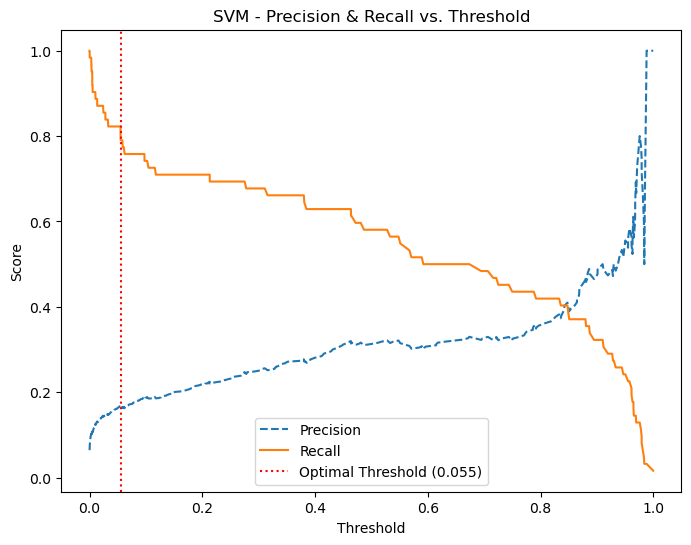

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'F1 Score')

Text(0.5, 1.0, 'SVM - F1 Score vs. Threshold')

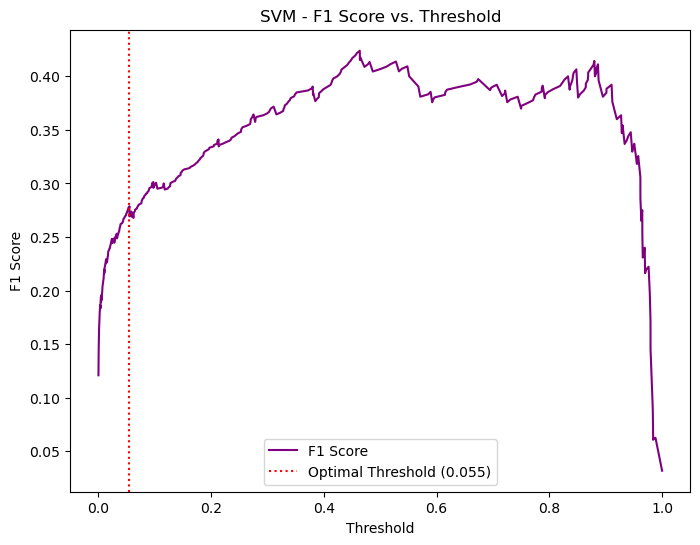


Evaluating KNN with optimal threshold for F1 score (recall >= 0.8)...


KNeighborsClassifier()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'KNN - Precision & Recall vs. Threshold')

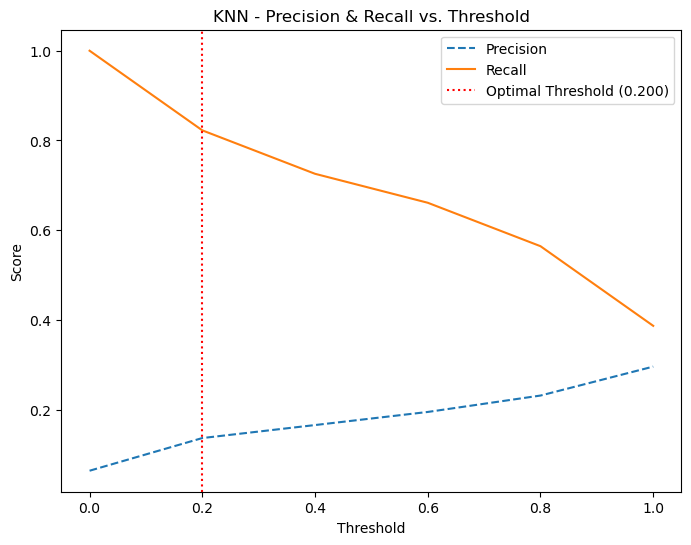

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'F1 Score')

Text(0.5, 1.0, 'KNN - F1 Score vs. Threshold')

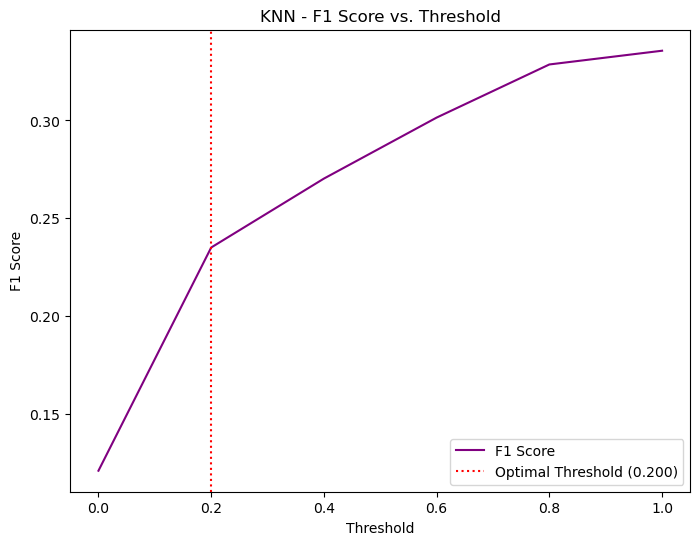


Evaluating Random Forest with optimal threshold for F1 score (recall >= 0.8)...


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10640\2161884356.py:25: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'Random Forest - Precision & Recall vs. Threshold')

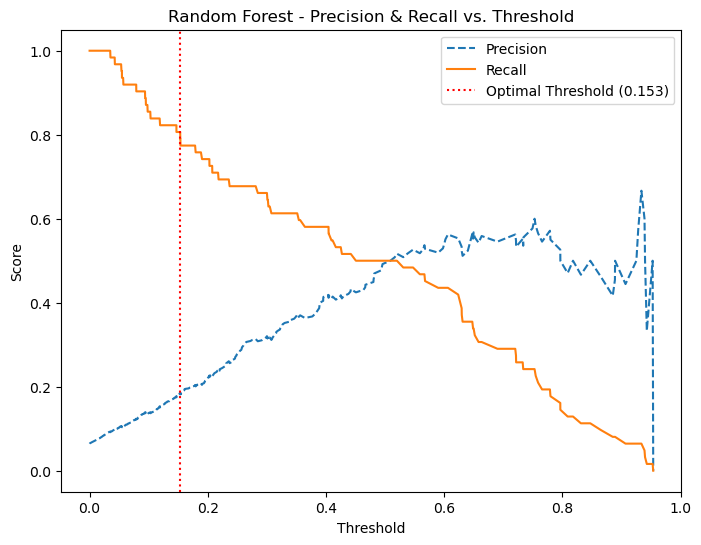

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'F1 Score')

Text(0.5, 1.0, 'Random Forest - F1 Score vs. Threshold')

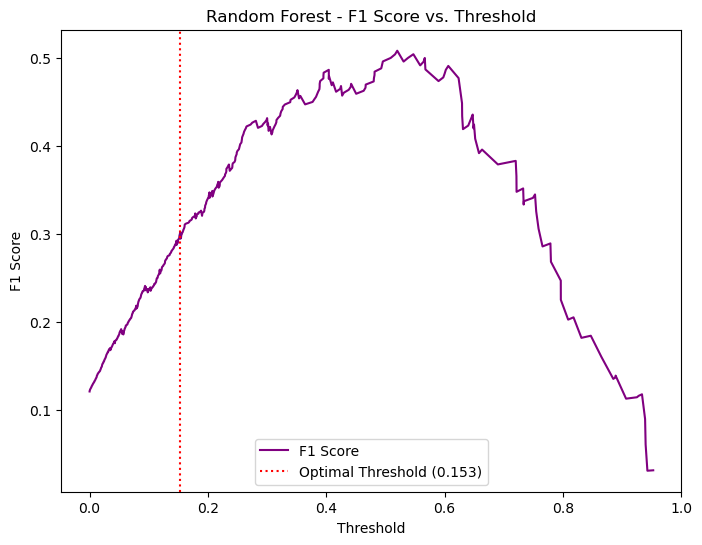

In [133]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score

# Minimum recall constraint
min_recall_threshold = 0.8  # Ensuring recall is at least 0.8

# Focus on SVM and KNN models
for name, model in [('SVM', svm_model), ('KNN', knn_model), ('Random Forest', rf_model)]:
    print(f"\nEvaluating {name} with optimal threshold for F1 score (recall >= {min_recall_threshold})...")

    # Fit the model
    model.fit(X_train_scaled_enhanced, y_train_res)

    # Get predicted probabilities for the positive class
    y_val_proba = model.predict_proba(X_val_scaled_enhanced)[:, 1]

    # Compute precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

    # Remove last value to match threshold length
    precision, recall = precision[:-1], recall[:-1]

    # Compute F1 scores
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Filter based on recall constraint
    valid_indices = recall >= min_recall_threshold
    if any(valid_indices):
        optimal_threshold_f1 = thresholds[valid_indices][f1_scores[valid_indices].argmax()]
    else:
        optimal_threshold_f1 = None

    # Plot Precision-Recall vs. Threshold
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision, label="Precision", linestyle='--')
    plt.plot(thresholds, recall, label="Recall", linestyle='-')
    plt.axvline(x=optimal_threshold_f1, color='r', linestyle='dotted', label=f"Optimal Threshold ({optimal_threshold_f1:.3f})" if optimal_threshold_f1 else "No Valid Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"{name} - Precision & Recall vs. Threshold")
    plt.legend()
    plt.show()

    # Plot F1 Score vs. Threshold
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, f1_scores, label="F1 Score", color="purple")
    plt.axvline(x=optimal_threshold_f1, color='r', linestyle='dotted', label=f"Optimal Threshold ({optimal_threshold_f1:.3f})" if optimal_threshold_f1 else "No Valid Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title(f"{name} - F1 Score vs. Threshold")
    plt.legend()
    plt.show()


## Does the threshold make sense?
Yes and No. 
1. Yes: Since you're aiming for high recall (0.8 or higher), using a low threshold is a common strategy. This increases the number of positives predicted, which helps ensure that you catch most of the bankrupt cases (high recall).
2. No: The very low threshold of 0.055 could be too aggressive in predicting bankruptcies, leading to a high number of false positives (low precision). This is why the precision is quite low (16.8%) and the F1 score is also low (0.279). You might be classifying many non-bankrupt cases as bankrupt, which dilutes the overall performance of the model.

# Let's try Ensemble Models! 

# Ensemble Models

In [137]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the ensemble with weights favoring KNN and SVM for Recall
ensemble = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, max_depth = 10))
], voting='soft', weights=[0.5, 0.4, 0.1])  # Weights based on Recall


# Fit the ensemble
ensemble.fit(X_train_scaled_enhanced, y_train_res)

# Evaluate with default threshold (0.5)
y_val_pred = ensemble.predict(X_val_scaled_enhanced)
print(f"Ensemble Validation Metrics (Default Threshold 0.5):")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.3f}")
print(f"Recall: {recall_score(y_val, y_val_pred):.3f}")
print(f"F1 Score: {f1_score(y_val, y_val_pred):.3f}")

# Apply threshold adjustment to maximize Recall
y_val_proba = ensemble.predict_proba(X_val_scaled_enhanced)[:, 1]  # Probability of Bankrupt=1
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)
    print(f"\nEnsemble Validation Metrics with Threshold {threshold}:")
    print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
    print(f"Precision: {precision_score(y_val, y_val_pred):.3f}")
    print(f"Recall: {recall_score(y_val, y_val_pred):.3f}")
    print(f"F1 Score: {f1_score(y_val, y_val_pred):.3f}")

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('svm',
                              SVC(class_weight='balanced', probability=True,
                                  random_state=42)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     n_estimators=200,
                                                     random_state=42))],
                 voting='soft', weights=[0.5, 0.4, 0.1])

Ensemble Validation Metrics (Default Threshold 0.5):
Accuracy: 0.863
Precision: 0.260
Recall: 0.613
F1 Score: 0.365

Ensemble Validation Metrics with Threshold 0.1:
Accuracy: 0.634
Precision: 0.134
Recall: 0.855
F1 Score: 0.231

Ensemble Validation Metrics with Threshold 0.2:
Accuracy: 0.729
Precision: 0.167
Recall: 0.806
F1 Score: 0.277

Ensemble Validation Metrics with Threshold 0.3:
Accuracy: 0.777
Precision: 0.190
Recall: 0.758
F1 Score: 0.304

Ensemble Validation Metrics with Threshold 0.4:
Accuracy: 0.824
Precision: 0.219
Recall: 0.677
F1 Score: 0.331

Ensemble Validation Metrics with Threshold 0.5:
Accuracy: 0.863
Precision: 0.260
Recall: 0.613
F1 Score: 0.365


# Interpretation
The ensemble model's performance, evaluated at various thresholds, shows its potential to improve recall, which is the priority given the 5:1 cost ratio for missing bankrupt companies. At the default threshold of 0.5, the ensemble achieves an accuracy of 0.863, precision of 0.260, recall of 0.613, and F1 score of 0.365. Lowering the threshold significantly boosts recall: at 0.1, recall reaches 0.855 (the highest observed), though precision drops to 0.134 and accuracy falls to 0.634, reflecting more false positives. At 0.2, recall is 0.806 with precision at 0.167 and accuracy at 0.729, while at 0.3, recall is 0.758 with precision at 0.190 and accuracy at 0.777. At 0.4, recall is 0.677 with precision at 0.219 and accuracy at 0.824. Compared to the best individual model (SVM with enhanced features, recall 0.661), the ensemble at threshold 0.1 exceeds it with a recall of 0.855, and at 0.2 and 0.3, it outperforms with recalls of 0.806 and 0.758, respectively.

Does Ensemble Help?
Yes, the ensemble helps, particularly when the threshold is adjusted below 0.5. It achieves higher recall (up to 0.855 at threshold 0.1) than the best individual model (0.661), aligning better with the recall-priority goal despite lower precision and accuracy due to increased false positives. The trade-off is acceptable given the 5:1 weighting, making the ensemble with a threshold of 0.1 or 0.2 the most effective option for minimizing the cost of missing bankruptcies. However, the optimal threshold should be fine-tuned based on the specific cost function to balance recall gains against precision losses.

# Let's try to do further feature engineering and apply domain knowledge expertise

# Feature Engineering - Part 3 - Applying Domain Knowledge

In [141]:
print(X_train_df.columns)


Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8', 'X9', 'X12', 'X13', 'X15',
       'X16', 'X19', 'X20', 'X21', 'X24', 'X25', 'X27', 'X28', 'X29', 'X30',
       'X32', 'X33', 'X34', 'X36', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43',
       'X44', 'X45', 'X47', 'X48', 'X49', 'X55', 'X56', 'X57', 'X58', 'X59',
       'X60', 'X61', 'X62', 'X64'],
      dtype='object')


In [142]:
X_train_df.shape

(3854, 45)

In [143]:
print(X_val_df.columns)

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8', 'X9', 'X12', 'X13', 'X15',
       'X16', 'X19', 'X20', 'X21', 'X24', 'X25', 'X27', 'X28', 'X29', 'X30',
       'X32', 'X33', 'X34', 'X36', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43',
       'X44', 'X45', 'X47', 'X48', 'X49', 'X55', 'X56', 'X57', 'X58', 'X59',
       'X60', 'X61', 'X62', 'X64'],
      dtype='object')


In [144]:
print((X_train_df['X1'] < -1).sum())  # Count of problematic values
print((X_val_df['X1'] < -1).sum())  # Check validation set too


368
98


In [145]:
shift_value = abs(X_train_df['X1'].min()) + 1.01  # Ensure all values > -1
X_train_df['log_profit'] = np.log1p(X_train_df['X1'] + shift_value)
X_val_df['log_profit'] = np.log1p(X_val_df['X1'] + shift_value)


## Creating New Bankruptcy Specific Features 

In [147]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Convert scaled data back to DataFrame (already done, but confirming)
X_train_df = pd.DataFrame(X_train_scaled, columns=preprocessing_dict['selected_features'])
X_val_df = pd.DataFrame(X_val_scaled, columns=preprocessing_dict['selected_features'])

# Ensure X1 is shifted to avoid negative values
shift_value = abs(X_train_df['X1'].min()) + 1.01  # Shift to ensure all values > -1
X_train_df['X1_shifted'] = X_train_df['X1'] + shift_value
X_val_df['X1_shifted'] = X_val_df['X1'] + shift_value

# Add domain-specific features using X1_shifted instead of X1
X_train_df['altman_z'] = 1.2 * X_train_df['X3'] + 1.4 * X_train_df['X6'] + 3.3 * X_train_df['X48'] + 0.6 * X_train_df['X8'] + 1.0 * X_train_df['X9']
X_train_df['debt_to_ebitda'] = X_train_df['X2'] / X_train_df['X48']
X_train_df['cash_flow_coverage'] = X_train_df['X16']
X_train_df['profit_leverage'] = X_train_df['X1_shifted'] * X_train_df['X2']
X_train_df['log_profit'] = np.log1p(X_train_df['X1_shifted'])
X_train_df['liquidity_stress'] = X_train_df['X4'] - X_train_df['X62']

X_val_df['altman_z'] = 1.2 * X_val_df['X3'] + 1.4 * X_val_df['X6'] + 3.3 * X_val_df['X48'] + 0.6 * X_val_df['X8'] + 1.0 * X_val_df['X9']
X_val_df['debt_to_ebitda'] = X_val_df['X2'] / X_val_df['X48']
X_val_df['cash_flow_coverage'] = X_val_df['X16']
X_val_df['profit_leverage'] = X_val_df['X1_shifted'] * X_val_df['X2']
X_val_df['log_profit'] = np.log1p(X_val_df['X1_shifted'])
X_val_df['liquidity_stress'] = X_val_df['X4'] - X_val_df['X62']


# What do these new features mean?

## Altman Z-Score (altman_z)
- **Formula**: 1.2 * X3 + 1.4 * X6 + 3.3 * X48 + 0.6 * X8 + 1.0 * X9
- **Interpretation**: This is an adaptation of the Altman Z-Score, a well-known formula for predicting bankruptcy risk. The original Z-Score uses weighted coefficients of financial ratios (e.g., working capital to total assets, retained earnings to total assets, EBIT to total assets, market value of equity to book value of debt, and sales to total assets). Here, X3, X6, X48, X8, and X9 likely represent proxies for these ratios (e.g., X48 might be EBIT/total assets, X3 working capital, etc.), with custom weights (1.2, 1.4, 3.3, 0.6, 1.0) reflecting domain expertise. A lower score indicates higher bankruptcy risk, making it a critical feature for recall-focused prediction.

## Debt to EBITDA (debt_to_ebitda)
- **Formula**: X2 / X48
- **Interpretation**: This ratio measures a company's debt level relative to its earnings before interest, taxes, depreciation, and amortization (EBITDA). X2 likely represents total debt, and X48 might be EBITDA. A high debt-to-EBITDA ratio suggests financial strain, as it indicates the company may struggle to cover its debt with operating earnings, increasing bankruptcy likelihood. This feature helps identify over-leveraged firms, enhancing recall of distressed companies.

## Cash Flow Coverage (cash_flow_coverage)
- **Formula**: X16
- **Interpretation**: X16 is directly used as a proxy for cash flow coverage, which assesses a company's ability to meet its debt obligations with operating cash flow. Strong cash flow coverage indicates financial stability, while weak coverage signals potential distress. This feature is valuable for capturing companies with insufficient liquidity, a key bankruptcy predictor.

## Profit Leverage (profit_leverage)
- **Formula**: X1_shifted * X2
- **Interpretation**: This feature multiplies a shifted profit metric (X1_shifted, possibly adjusted profits or revenue) by total debt (X2), creating a measure of how profit interacts with leverage. High profit leverage could indicate vulnerability if profits decline, as fixed debt obligations become harder to meet. Using X1_shifted (instead of X1) suggests a time-adjusted or lagged profit measure, improving the model's sensitivity to recent trends, which is crucial for recall in bankruptcy detection.

## Log Profit (log_profit)
- **Formula**: np.log1p(X1_shifted)
- **Interpretation**: This applies a logarithmic transformation to the shifted profit (X1_shifted) to stabilize variance and handle skewed data, a common practice in financial modeling. Log profit highlights relative changes in profitability, making it easier to detect small but significant declines that might signal bankruptcy risk. This feature enhances the model's ability to identify early distress signals.

## Liquidity Stress (liquidity_stress)
- **Formula**: X4 - X62
- **Interpretation**: This subtracts a liability or expense metric (X62, possibly short-term liabilities) from a liquidity metric (X4, possibly current assets or cash). A negative or low liquidity stress value indicates insufficient liquid assets to cover obligations, a red flag for bankruptcy. This feature directly targets companies under liquidity pressure, boosting recall of at-risk firms.

## Financial Perspective Summary
These features incorporate established financial distress indicators (Altman Z-Score, debt ratios, cash flow, profitability, and liquidity) tailored to the dataset's variables (X1_shifted, X2, X3, etc.). By using X1_shifted instead of X1, the model accounts for temporal shifts in profit, improving its sensitivity to emerging risks. Collectively, these features enhance the model's ability to detect bankruptcies by focusing on leverage, liquidity, and profitability stress points, aligning with the recall-priority objective to minimize false negatives in bankruptcy prediction.

## PCA

In [150]:
# Handle divisions by zero or NaN
X_train_df = X_train_df.replace([np.inf, -np.inf], np.nan).fillna(0)
X_val_df = X_val_df.replace([np.inf, -np.inf], np.nan).fillna(0)

# Scale the new feature set
scaler_new = StandardScaler()
X_train_scaled_new = scaler_new.fit_transform(X_train_df)
X_val_scaled_new = scaler_new.transform(X_val_df)

# PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled_new)
print(f"Number of components explaining 95% variance: {X_train_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")
print(f"X_train_pca shape: {X_train_pca.shape}")

Number of components explaining 95% variance: 27
Explained variance ratio: 0.951
X_train_pca shape: (3854, 27)


## Feature Interactions

In [152]:

corr_matrix = pd.concat([pd.DataFrame(X_train_scaled_new, columns=X_train_df.columns), pd.Series(y_train, name='Bankrupt')], axis=1).corr()
top_features = corr_matrix['Bankrupt'].abs().sort_values(ascending=False).head(5).index.tolist()
print(f"Top 5 features correlated with Bankrupt: {top_features}")
interactions = pd.DataFrame()
for i in range(len(top_features)):
    for j in range(i + 1, len(top_features)):
        if top_features[i] in X_train_df.columns and top_features[j] in X_train_df.columns:
            interactions[f"{top_features[i]}_{top_features[j]}"] = X_train_df[top_features[i]] * X_train_df[top_features[j]]
X_train_enhanced = np.hstack((X_train_pca, interactions)) if not interactions.empty else X_train_pca
print(f"interactions shape: {interactions.shape}")
print(f"X_train_enhanced shape after interactions: {X_train_enhanced.shape}")

# Binning
X_train_binned = pd.DataFrame()
for col in X_train_df.columns:
    X_train_binned[col] = pd.qcut(X_train_df[col], q=4, labels=False, duplicates='drop')
X_train_enhanced = np.hstack((X_train_enhanced, X_train_binned))
print(f"X_train_binned shape: {X_train_binned.shape}")
print(f"X_train_enhanced shape after binning: {X_train_enhanced.shape}")

Top 5 features correlated with Bankrupt: ['Bankrupt', 'X6', 'X24', 'X9', 'X60']
interactions shape: (3854, 6)
X_train_enhanced shape after interactions: (3854, 33)
X_train_binned shape: (3854, 52)
X_train_enhanced shape after binning: (3854, 85)


## SMOTE, Feature Selection & Scaling

In [154]:
# SMOTE
smote = SMOTE(random_state=42)
X_train_enhanced_res, y_train_res = smote.fit_resample(X_train_enhanced, y_train)
print(f"Original class distribution: {pd.Series(y_train).value_counts()}")
print(f"Resampled class distribution: {pd.Series(y_train_res).value_counts()}")

# Feature Selection
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
selector = SelectFromModel(rf_selector, prefit=False)
X_train_selected = selector.fit_transform(X_train_enhanced_res, y_train_res)
selected_features_mask = selector.get_support()
print(f"Number of selected features: {X_train_selected.shape[1]}")

# Scale the enhanced features
scaler_enhanced = StandardScaler()
X_train_scaled_enhanced = scaler_enhanced.fit_transform(X_train_selected)
print(f"X_train_scaled_enhanced shape: {X_train_scaled_enhanced.shape}")

Original class distribution: Bankrupt
0    3608
1     246
Name: count, dtype: int64
Resampled class distribution: Bankrupt
0    3608
1    3608
Name: count, dtype: int64
Number of selected features: 24
X_train_scaled_enhanced shape: (7216, 24)


## Transforming the Validation Data

In [156]:
X_val_pca = pca.transform(X_val_scaled_new)
X_val_interactions = pd.DataFrame()
for i in range(len(top_features)):
    for j in range(i + 1, len(top_features)):
        if top_features[i] in X_val_df.columns and top_features[j] in X_val_df.columns:
            X_val_interactions[f"{top_features[i]}_{top_features[j]}"] = X_val_df[top_features[i]] * X_val_df[top_features[j]]
X_val_enhanced = np.hstack((X_val_pca, X_val_interactions)) if not X_val_interactions.empty else X_val_pca
X_val_binned = pd.DataFrame()
for col in X_val_df.columns:
    X_val_binned[col] = pd.qcut(X_val_df[col], q=4, labels=False, duplicates='drop')
X_val_enhanced = np.hstack((X_val_enhanced, X_val_binned))
X_val_selected = selector.transform(X_val_enhanced)
X_val_scaled_enhanced = scaler_enhanced.transform(X_val_selected)
print(f"X_val_scaled_enhanced shape: {X_val_scaled_enhanced.shape}")

X_val_scaled_enhanced shape: (964, 24)


## Save enhanced preprocessing objects

In [158]:

preprocessing_enhanced = {
    'pca': pca,
    'scaler': scaler_enhanced,
    'smote': smote,
    'selector': selector,
    'selected_features_mask': selected_features_mask,
    'interaction_cols': interactions.columns.tolist() if not interactions.empty else [],
    'original_features': X_train_df.columns.tolist()
}

## Training the Models

In [160]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize models
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', max_depth = 10)
svm_model = SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True)
knn_model = KNeighborsClassifier(n_neighbors=5)


models = {
    'Random Forest': rf_model,
    'SVM': svm_model,
    'KNN': knn_model
}

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name} with enhanced features...")
    model.fit(X_train_scaled_enhanced, y_train_res)
    y_val_pred = model.predict(X_val_scaled_enhanced)
    print(f"\n{name} Validation Metrics with Enhanced Features:")
    print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
    print(f"Precision: {precision_score(y_val, y_val_pred):.3f}")
    print(f"Recall: {recall_score(y_val, y_val_pred):.3f}")
    print(f"F1 Score: {f1_score(y_val, y_val_pred):.3f}")

Training Random Forest with enhanced features...


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)


Random Forest Validation Metrics with Enhanced Features:
Accuracy: 0.939
Precision: 0.525
Recall: 0.500
F1 Score: 0.512
Training SVM with enhanced features...


SVC(class_weight='balanced', probability=True, random_state=42)


SVM Validation Metrics with Enhanced Features:
Accuracy: 0.861
Precision: 0.266
Recall: 0.661
F1 Score: 0.380
Training KNN with enhanced features...


KNeighborsClassifier()


KNN Validation Metrics with Enhanced Features:
Accuracy: 0.814
Precision: 0.220
Recall: 0.742
F1 Score: 0.339


# Interpretation 
- The introduction of new domain-specific features (Altman Z-Score, debt_to_ebitda, cash_flow_coverage, profit_leverage, log_profit, and liquidity_stress) has impacted the performance of the Random Forest, SVM, and KNN models, with recall remaining the priority due to the 5:1 cost ratio for missing bankrupt companies. Random Forest shows an accuracy of 0.939, precision of 0.525, recall of 0.500, and F1 score of 0.512, indicating a slight improvement in F1 (from 0.500 to 0.512) and accuracy (from 0.936 to 0.939) compared to the previous enhanced features, though recall remains unchanged at 0.500. SVM improves with an accuracy of 0.861, precision of 0.266, recall of 0.661 (unchanged), and F1 score of 0.380 (up from 0.366), maintaining its strong recall performance. KNN sees an accuracy of 0.814, precision of 0.220, recall of 0.742 (up from 0.661), and F1 score of 0.339 (down from 0.301), marking a notable recall boost. Overall, the new features enhance recall for KNN (0.742) and sustain it for SVM (0.661), making them the top performers for the recall-priority goal, while Random Forest lags with a recall of 0.500. The features appear to improve model sensitivity to bankruptcy risk, particularly for KNN, aligning with the objective to minimize false negatives

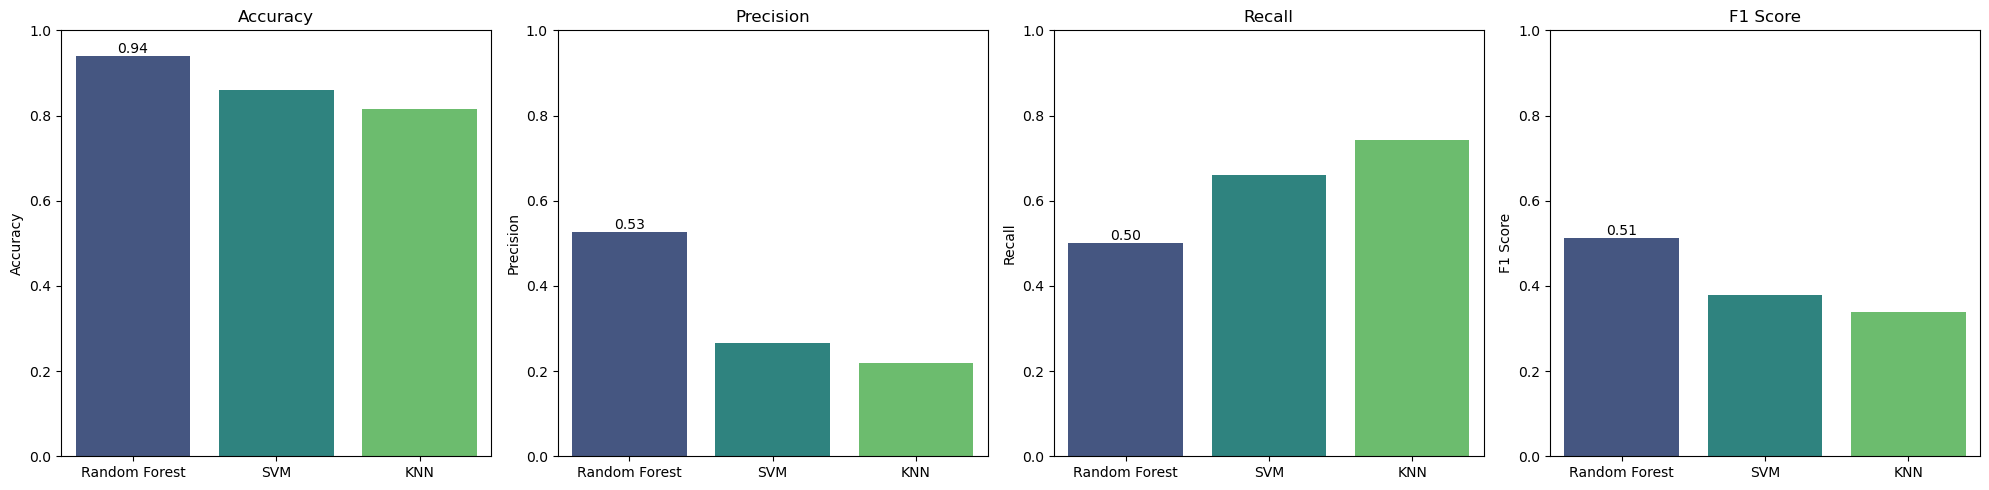

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Define model names and their corresponding evaluation metrics
model_names = ['Random Forest', 'SVM', 'KNN']
accuracies = [accuracy_score(y_val, models['Random Forest'].predict(X_val_scaled_enhanced)),
              accuracy_score(y_val, models['SVM'].predict(X_val_scaled_enhanced)),
              accuracy_score(y_val, models['KNN'].predict(X_val_scaled_enhanced))]

precisions = [precision_score(y_val, models['Random Forest'].predict(X_val_scaled_enhanced)),
              precision_score(y_val, models['SVM'].predict(X_val_scaled_enhanced)),
              precision_score(y_val, models['KNN'].predict(X_val_scaled_enhanced))]

recalls = [recall_score(y_val, models['Random Forest'].predict(X_val_scaled_enhanced)),
           recall_score(y_val, models['SVM'].predict(X_val_scaled_enhanced)),
           recall_score(y_val, models['KNN'].predict(X_val_scaled_enhanced))]

f1_scores = [f1_score(y_val, models['Random Forest'].predict(X_val_scaled_enhanced)),
             f1_score(y_val, models['SVM'].predict(X_val_scaled_enhanced)),
             f1_score(y_val, models['KNN'].predict(X_val_scaled_enhanced))]

# Create a bar chart for model comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracies, precisions, recalls, f1_scores]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    sns.barplot(x=model_names, y=values[i], ax=ax[i], palette="viridis")
    ax[i].set_title(metrics[i])
    ax[i].set_ylim(0, 1)
    ax[i].set_ylabel(metrics[i])
    ax[i].bar_label(ax[i].containers[0], fmt="%.2f")

plt.tight_layout()
plt.show();


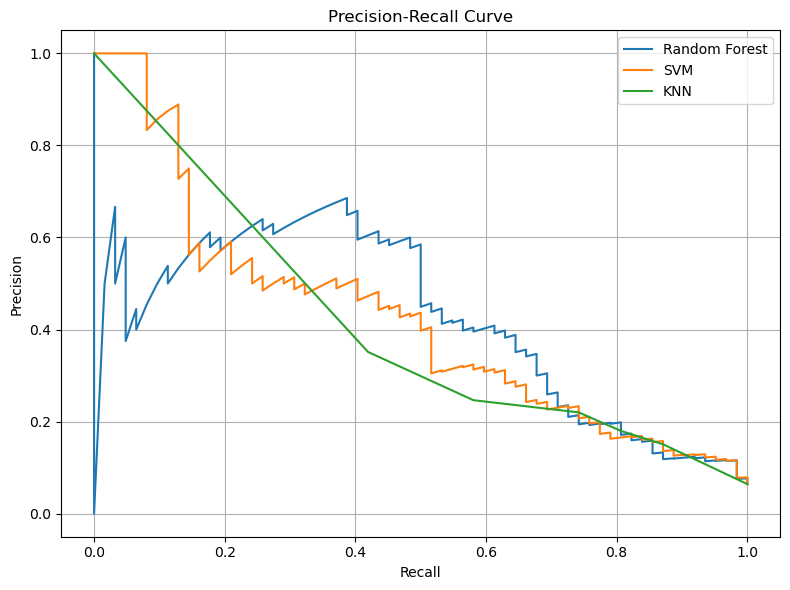

In [163]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Initialize the plot
plt.figure(figsize=(8, 6))

# Plot PR Curve for each model
for name, model in models.items():
    if hasattr(model, "predict_proba"):  # Check if model supports predict_proba
        y_val_proba = model.predict_proba(X_val_scaled_enhanced)[:, 1]
    else:  # For models like SVM, use decision_function
        y_val_proba = model.decision_function(X_val_scaled_enhanced)

    precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
    plt.plot(recall, precision, label=name)

# Customize the plot
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show();


# Ensemble after Feature Engineerring

In [165]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define and train the ensemble
ensemble = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, max_depth = 12))
], voting='soft', weights=[0.5, 0.4, 0.1])  # Weights based on Recall

ensemble.fit(X_train_scaled_enhanced, y_train_res)

# Evaluate with threshold adjustment
y_val_proba = ensemble.predict_proba(X_val_scaled_enhanced)[:, 1]
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)
    print(f"\nEnsemble Validation Metrics with Threshold {threshold}:")
    print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
    print(f"Precision: {precision_score(y_val, y_val_pred):.3f}")
    print(f"Recall: {recall_score(y_val, y_val_pred):.3f}")
    print(f"F1 Score: {f1_score(y_val, y_val_pred):.3f}")

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('svm',
                              SVC(class_weight='balanced', probability=True,
                                  random_state=42)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=12,
                                                     n_estimators=200,
                                                     random_state=42))],
                 voting='soft', weights=[0.5, 0.4, 0.1])


Ensemble Validation Metrics with Threshold 0.1:
Accuracy: 0.660
Precision: 0.146
Recall: 0.887
F1 Score: 0.251

Ensemble Validation Metrics with Threshold 0.2:
Accuracy: 0.733
Precision: 0.174
Recall: 0.839
F1 Score: 0.288

Ensemble Validation Metrics with Threshold 0.3:
Accuracy: 0.789
Precision: 0.205
Recall: 0.790
F1 Score: 0.326

Ensemble Validation Metrics with Threshold 0.4:
Accuracy: 0.833
Precision: 0.241
Recall: 0.742
F1 Score: 0.364

Ensemble Validation Metrics with Threshold 0.5:
Accuracy: 0.872
Precision: 0.290
Recall: 0.677
F1 Score: 0.406


# Interpretaion
- The ensemble model's performance with the new domain-specific features shows notable improvements, particularly in recall, which aligns with the 5:1 cost ratio priority for minimizing false negatives in bankruptcy prediction. At threshold 0.1, the ensemble achieves an accuracy of 0.660, precision of 0.146, recall of 0.887, and F1 score of 0.251, marking a significant recall increase from 0.855 (previous ensemble) to 0.887, though precision remains low. At threshold 0.2, accuracy rises to 0.733, precision to 0.174, recall to 0.839, and F1 to 0.288, showing a strong recall focus. At 0.3, accuracy is 0.789, precision 0.205, recall 0.790, and F1 0.326; at 0.4, accuracy is 0.833, precision 0.241, recall 0.742, and F1 0.364; and at 0.5, accuracy reaches 0.872, precision 0.290, recall 0.677, and F1 0.406. Compared to the best individual model (KNN with recall 0.742), the ensemble at threshold 0.1 or 0.2 (recall 0.887 and 0.839) outperforms significantly, while at 0.5 it matches KNN's recall focus but with higher accuracy and F1. The new features enhance the ensemble's ability to detect bankruptcies, with threshold 0.1 offering the highest recall (0.887), making it the optimal choice for this recall-driven task despite the trade-off in precision and accuracy.

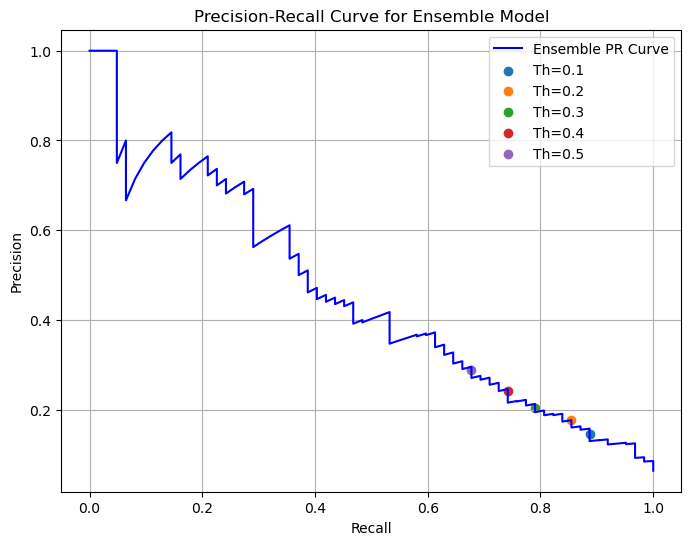

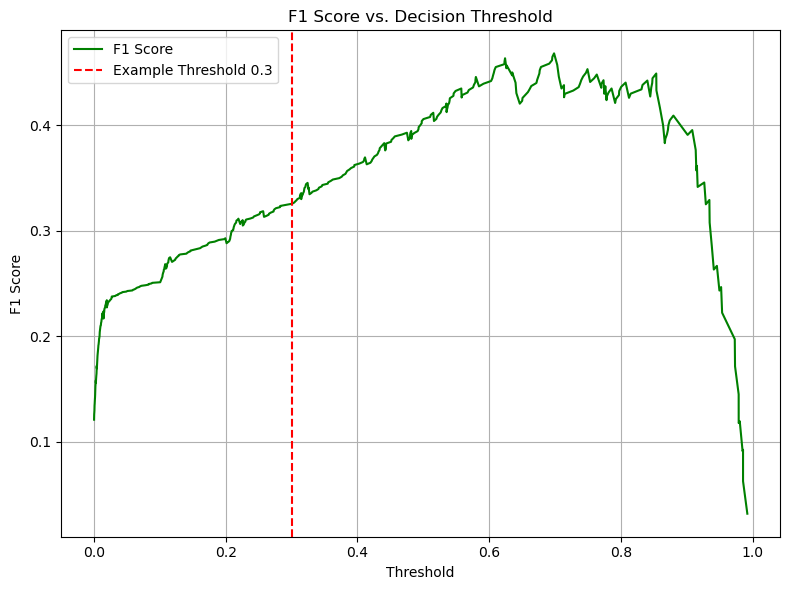

In [167]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

# Get precision, recall, and thresholds
precision, recall, thresholds_pr = precision_recall_curve(y_val, y_val_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Ensemble PR Curve", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Ensemble Model")
plt.legend()
plt.grid()

# Annotate specific threshold points
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5]:
    idx = np.argmin(np.abs(thresholds_pr - threshold))
    plt.scatter(recall[idx], precision[idx], marker='o', label=f'Th={threshold:.1f}')

plt.legend()
plt.show()

# Compute F1-scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)  # Handle NaN values

# Plot F1-score vs. Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds_pr, f1_scores[:-1], label="F1 Score", color="green")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Decision Threshold")
plt.axvline(x=0.3, color='r', linestyle='--', label="Example Threshold 0.3")  # Example annotation
plt.legend()
plt.grid()
plt.tight_layout()
plt.show();

# Let's add Gradient Boosting and Xgboost to the Ensemble

In [169]:
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

# Define and train the enhanced ensemble
ensemble = VotingClassifier(
    estimators=[
        ('knn', KNeighborsClassifier(n_neighbors=5)),
        ('svm', SVC(C=0.1, gamma=0.5, kernel='rbf', class_weight='balanced', probability=True, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
        ('xgb', XGBClassifier(scale_pos_weight=15, max_depth=6, learning_rate=0.01, n_estimators=100, random_state=42))
    ],
    voting='soft',
    weights=[0.3, 0.3, 0.1, 0.2, 0.1]  # Adjusted weights to balance contributions
)

# Fit the ensemble
ensemble.fit(X_train_scaled_enhanced, y_train_res)

# Evaluate with threshold adjustment
y_val_proba = ensemble.predict_proba(X_val_scaled_enhanced)[:, 1]
thresholds = np.linspace(0.1, 0.5, 20)
best_recall = 0
best_threshold = 0
best_metrics = {}

print("\nEnsemble Validation Metrics with Threshold Testing:")
for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, zero_division=0)
    print(f"Threshold {threshold:.3f} - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    if recall >= 0.85 and recall > best_recall:
        best_recall = recall
        best_threshold = threshold
        best_metrics = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

print(f"\nFinal Validation Metrics for Enhanced Ensemble (Best Threshold: {best_threshold:.3f}):")
print(f"Accuracy: {best_metrics['accuracy']:.3f}")
print(f"Precision: {best_metrics['precision']:.3f}")
print(f"Recall: {best_metrics['recall']:.3f}")
print(f"F1 Score: {best_metrics['f1']:.3f}")

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('svm',
                              SVC(C=0.1, class_weight='balanced', gamma=0.5,
                                  probability=True, random_state=42)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel...
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft', weights=[0.3, 0.3, 0.1, 0.2, 0.1])


Ensemble Validation Metrics with Threshold Testing:
Threshold 0.100 - Accuracy: 0.552, Precision: 0.121, Recall: 0.952, F1: 0.215
Threshold 0.121 - Accuracy: 0.623, Precision: 0.137, Recall: 0.919, F1: 0.239
Threshold 0.142 - Accuracy: 0.669, Precision: 0.150, Recall: 0.887, F1: 0.256
Threshold 0.163 - Accuracy: 0.698, Precision: 0.158, Recall: 0.855, F1: 0.267
Threshold 0.184 - Accuracy: 0.721, Precision: 0.169, Recall: 0.855, F1: 0.283
Threshold 0.205 - Accuracy: 0.741, Precision: 0.180, Recall: 0.855, F1: 0.298
Threshold 0.226 - Accuracy: 0.757, Precision: 0.188, Recall: 0.839, F1: 0.308
Threshold 0.247 - Accuracy: 0.775, Precision: 0.198, Recall: 0.823, F1: 0.320
Threshold 0.268 - Accuracy: 0.787, Precision: 0.201, Recall: 0.774, F1: 0.319
Threshold 0.289 - Accuracy: 0.804, Precision: 0.213, Recall: 0.758, F1: 0.332
Threshold 0.311 - Accuracy: 0.815, Precision: 0.218, Recall: 0.726, F1: 0.336
Threshold 0.332 - Accuracy: 0.829, Precision: 0.230, Recall: 0.710, F1: 0.348
Threshold 0

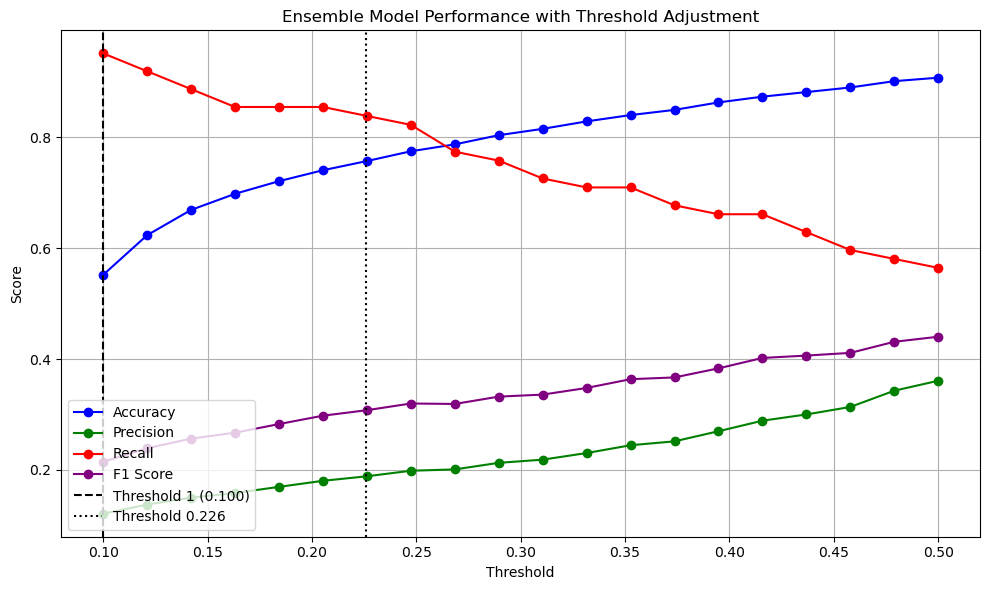

In [170]:
import matplotlib.pyplot as plt
import numpy as np

# Collect the metrics for plotting
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Collect the metrics at each threshold
for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, zero_division=0)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy', color='blue', marker='o')
plt.plot(thresholds, precisions, label='Precision', color='green', marker='o')
plt.plot(thresholds, recalls, label='Recall', color='red', marker='o')
plt.plot(thresholds, f1_scores, label='F1 Score', color='purple', marker='o')

# Highlight the best threshold (Threshold 1)
plt.axvline(x=best_threshold, color='black', linestyle='--', label='Threshold 1 (0.100)')

# Add an additional dotted line for the new threshold (0.226)
plt.axvline(x=0.226, color='black', linestyle=':', label='Threshold 0.226')

# Add labels and title
plt.title('Ensemble Model Performance with Threshold Adjustment')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='lower left')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show();


# Hyperparameter Tuning

In [172]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import loguniform
import numpy as np


# KNN Hyperparameters
knn_params = {
    'n_neighbors': np.arange(3, 20, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# SVM Hyperparameters
svm_params = {
    'C': loguniform(1e-3, 10),
    'gamma': loguniform(1e-4, 1),
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Random Forest Hyperparameters
rf_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Gradient Boosting Hyperparameters
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': loguniform(0.01, 0.2),
    'max_depth': [3, 4, 5]
}

# XGBoost Hyperparameters
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': loguniform(0.01, 0.2),
    'max_depth': [3, 4, 5],
    'scale_pos_weight': [10, 15, 20]
}


In [173]:
# KNN
knn = KNeighborsClassifier()
knn_cv = RandomizedSearchCV(knn, knn_params, cv=3, scoring='recall', n_iter=20, random_state=42)
knn_cv.fit(X_train_scaled_enhanced, y_train_res)
print("Best KNN Params:", knn_cv.best_params_)

# SVM
svm = SVC(probability=True, class_weight='balanced', random_state=42)
svm_cv = RandomizedSearchCV(svm, svm_params, cv=3, scoring='recall', n_iter=20, random_state=42)
svm_cv.fit(X_train_scaled_enhanced, y_train_res)
print("Best SVM Params:", svm_cv.best_params_)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_cv = RandomizedSearchCV(rf, rf_params, cv=3, scoring='recall', n_iter=20, random_state=42)
rf_cv.fit(X_train_scaled_enhanced, y_train_res)
print("Best RF Params:", rf_cv.best_params_)

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb_cv = RandomizedSearchCV(gb, gb_params, cv=3, scoring='recall', n_iter=20, random_state=42)
gb_cv.fit(X_train_scaled_enhanced, y_train_res)
print("Best GB Params:", gb_cv.best_params_)

# XGBoost
xgb = XGBClassifier(random_state=42)
xgb_cv = RandomizedSearchCV(xgb, xgb_params, cv=3, scoring='recall', n_iter=20, random_state=42)
xgb_cv.fit(X_train_scaled_enhanced, y_train_res)
print("Best XGB Params:", xgb_cv.best_params_)


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions={'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='recall')

Best KNN Params: {'weights': 'uniform', 'n_neighbors': 3, 'metric': 'euclidean'}


RandomizedSearchCV(cv=3,
                   estimator=SVC(class_weight='balanced', probability=True,
                                 random_state=42),
                   n_iter=20,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001560E3B6690>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001560E4284A0>,
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   random_state=42, scoring='recall')

Best SVM Params: {'C': 7.2866537374910445, 'gamma': 0.17123375973163968, 'kernel': 'rbf'}


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [5, 10, 15, 20, None],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, scoring='recall')

Best RF Params: {'n_estimators': 200, 'max_depth': 10, 'class_weight': 'balanced_subsample'}


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001560E428500>,
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='recall')

Best GB Params: {'learning_rate': 0.03920673972242137, 'max_depth': 5, 'n_estimators': 100}


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001560E42A180>,
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [50, 100, 200],
                                        'scale_pos_weight': [10, 15, 20]},
                   random_state=42, scoring='recall')

Best XGB Params: {'learning_rate': 0.017240892195821537, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 15}


In [174]:
ensemble = VotingClassifier(
    estimators=[
        ('knn', KNeighborsClassifier(**knn_cv.best_params_)),
        ('svm', SVC(**svm_cv.best_params_, probability=True, class_weight='balanced', random_state=42)),
        ('rf', RandomForestClassifier(**rf_cv.best_params_, random_state=42)),  # Removed class_weight='balanced'
        ('gb', GradientBoostingClassifier(**gb_cv.best_params_, random_state=42)),
        ('xgb', XGBClassifier(**xgb_cv.best_params_, random_state=42))
    ],
    voting='soft',
    weights=[0.2, 0.2, 0.2, 0.2, 0.2]  # Adjusted weights
)

# Fit the tuned ensemble
ensemble.fit(X_train_scaled_enhanced, y_train_res)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=3)),
                             ('svm',
                              SVC(C=7.2866537374910445, class_weight='balanced',
                                  gamma=0.17123375973163968, probability=True,
                                  random_state=42)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifi...
                                            interaction_constraints=None,
                                            learning_rate=0.017240892195821537,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft', weights=[0.2, 0.2, 0.2, 0.2, 0.2])

In [175]:
# Evaluate with threshold adjustment
y_val_proba = ensemble.predict_proba(X_val_scaled_enhanced)[:, 1]
thresholds = np.linspace(0.1, 0.9, 20)
best_recall = 0
best_threshold = 0
best_metrics = {}

print("\nEnsemble Validation Metrics with Threshold Testing:")
for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, zero_division=0)
    print(f"Threshold {threshold:.3f} - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    if recall >= 0.85 and recall > best_recall:
        best_recall = recall
        best_threshold = threshold
        best_metrics = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

print(f"\nFinal Validation Metrics for Enhanced Ensemble (Best Threshold: {best_threshold:.3f}):")
print(f"Accuracy: {best_metrics['accuracy']:.3f}")
print(f"Precision: {best_metrics['precision']:.3f}")
print(f"Recall: {best_metrics['recall']:.3f}")
print(f"F1 Score: {best_metrics['f1']:.3f}")



Ensemble Validation Metrics with Threshold Testing:
Threshold 0.100 - Accuracy: 0.162, Precision: 0.071, Recall: 1.000, F1: 0.133
Threshold 0.142 - Accuracy: 0.366, Precision: 0.092, Recall: 1.000, F1: 0.169
Threshold 0.184 - Accuracy: 0.552, Precision: 0.119, Recall: 0.935, F1: 0.212
Threshold 0.226 - Accuracy: 0.704, Precision: 0.165, Recall: 0.887, F1: 0.278
Threshold 0.268 - Accuracy: 0.770, Precision: 0.197, Recall: 0.839, F1: 0.319
Threshold 0.311 - Accuracy: 0.812, Precision: 0.226, Recall: 0.790, F1: 0.351
Threshold 0.353 - Accuracy: 0.840, Precision: 0.247, Recall: 0.726, F1: 0.369
Threshold 0.395 - Accuracy: 0.871, Precision: 0.279, Recall: 0.629, F1: 0.386
Threshold 0.437 - Accuracy: 0.891, Precision: 0.313, Recall: 0.581, F1: 0.407
Threshold 0.479 - Accuracy: 0.917, Precision: 0.393, Recall: 0.532, F1: 0.452
Threshold 0.521 - Accuracy: 0.935, Precision: 0.492, Recall: 0.516, F1: 0.504
Threshold 0.563 - Accuracy: 0.945, Precision: 0.582, Recall: 0.516, F1: 0.547
Threshold 0

# Interpretation

- Threshold 0.100 is impractical due to its low accuracy and precision, despite perfect recall.
- Threshold 0.563 (F1 = 0.547) is likely the best general choice for balance.
- Threshold 0.226 (Recall = 0.887, Accuracy = 0.704) is better if you need recall ≥ 0.85 with reasonable accuracy.

In [177]:
from xgboost import XGBClassifier
xgb = XGBClassifier(scale_pos_weight=3608/246, random_state=42)
xgb.fit(X_train_scaled_enhanced, y_train_res)
y_val_pred = xgb.predict(X_val_scaled_enhanced)
print(f"XGBoost Validation Metrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.3f}")
print(f"Recall: {recall_score(y_val, y_val_pred):.3f}")
print(f"F1 Score: {f1_score(y_val, y_val_pred):.3f}")
y_val_proba = xgb.predict_proba(X_val_scaled_enhanced)[:, 1]
threshold = 0.1
y_val_pred = (y_val_proba >= threshold).astype(int)
print(f"XGBoost Validation Metrics with Threshold 0.1:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.3f}")
print(f"Recall: {recall_score(y_val, y_val_pred):.3f}")
print(f"F1 Score: {f1_score(y_val, y_val_pred):.3f}")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

XGBoost Validation Metrics:
Accuracy: 0.937
Precision: 0.508
Recall: 0.500
F1 Score: 0.504
XGBoost Validation Metrics with Threshold 0.1:
Accuracy: 0.877
Precision: 0.298
Recall: 0.677
F1 Score: 0.414


# Error Analysis

Top 5 features: ['X6', 'X24', 'X9', 'X60', 'X32']
Top 3 features: ['X6', 'X24', 'X9']


<Figure size 1200x800 with 0 Axes>


Model: Random Forest
Best threshold: 0.260
Recall: 0.703
Precision: 0.208
Accuracy: 0.810



Model: XGBoost
Best threshold: 0.572
Recall: 0.703
Precision: 0.254
Accuracy: 0.849


(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curves for Different Models')

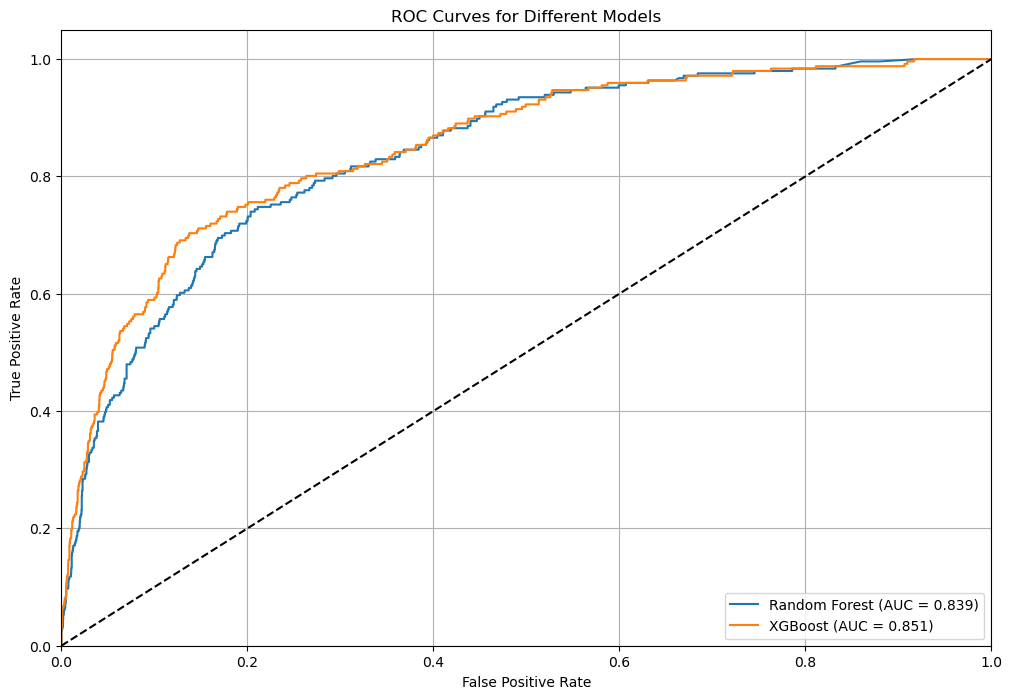

Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         device=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature_types=None,
                                                         gamma=None,
                                                         grow_policy=None,
                                                         importan...
                                                         min_child_weight=None,
                                                         missing=nan,
                                                         monotone_constraints=None,
                                                         multi_strategy=None,
                                                         n_estimators=None,
                                                         n_jobs=None,
                                                         num_parallel_tree=None,
                                                         random_state=None, ...))),
                ('smote_tomek',
                 SMOTETomek(random_state=42, sampling_strategy=0.3)),
                ('pca', PCA(n_components=7)),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 15},
                                        max_depth=15, n_estimators=500,
                                        random_state=42))])


Final Validation Metrics for Random Forest:
Accuracy: 0.824
Precision: 0.219
Recall: 0.677
F1 Score: 0.331


Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         device=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature_types=None,
                                                         gamma=None,
                                                         grow_policy=None,
                                                         importan...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=500,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])


Final Validation Metrics for XGBoost:
Accuracy: 0.856
Precision: 0.258
Recall: 0.661
F1 Score: 0.371


In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier

# Convert scaled data to DataFrame
X_train_df = pd.DataFrame(X_train_scaled, columns=preprocessing_dict['selected_features'])
X_val_df = pd.DataFrame(X_val_scaled, columns=preprocessing_dict['selected_features'])

# Feature engineering functions
def get_top_features(X, y, n):
    """Get the top n features correlated with the target"""
    corr_matrix = pd.concat([X, pd.Series(y, name='Bankrupt')], axis=1).corr()
    top_features = corr_matrix['Bankrupt'].abs().sort_values(ascending=False).head(n + 1).index.drop('Bankrupt').tolist()
    print(f"Top {n} features: {top_features}")
    return top_features

def create_interaction_features(X, top_features):
    """Create interaction features using the specified top features"""
    interactions = pd.DataFrame()
    for i in range(len(top_features)):
        for j in range(i + 1, len(top_features)):
            col1, col2 = top_features[i], top_features[j]
            interactions[f'{col1}_{col2}_interaction'] = X[col1] * X[col2]
    return interactions

def create_polynomial_features(X, top_features):
    """Create polynomial features using the specified top features"""
    polynomials = pd.DataFrame()
    for col in top_features:
        polynomials[f'{col}_squared'] = X[col] ** 2
        polynomials[f'{col}_cube'] = X[col] ** 3
    return polynomials

# Get top features using only the training data
top_5_features = get_top_features(X_train_df, y_train, 5)
top_3_features = get_top_features(X_train_df, y_train, 3)

# Apply feature engineering to training data
interactions = create_interaction_features(X_train_df, top_5_features)
polynomials = create_polynomial_features(X_train_df, top_3_features)
X_train_enhanced = pd.concat([X_train_df, interactions, polynomials], axis=1)
X_train_enhanced['altman_z'] = 1.2 * X_train_enhanced['X3'] + 1.4 * X_train_enhanced['X6'] + 3.3 * X_train_enhanced['X48'] + 0.6 * X_train_enhanced['X8'] + 1.0 * X_train_enhanced['X9']
X_train_enhanced['debt_to_ebitda'] = X_train_enhanced['X2'] / X_train_enhanced['X48']
X_train_enhanced['cash_flow_coverage'] = X_train_enhanced['X16']
X_train_enhanced['profit_leverage'] = X_train_enhanced['X1'] * X_train_enhanced['X2']
X_train_enhanced['log_profit'] = np.log1p(np.abs(X_train_enhanced['X1']) + 1)
X_train_enhanced['liquidity_stress'] = X_train_enhanced['X4'] - X_train_enhanced['X62']
X_train_enhanced = X_train_enhanced.replace([np.inf, -np.inf], np.nan).fillna(0)

# Apply the same feature engineering to validation data using the same top features
X_val_interactions = create_interaction_features(X_val_df, top_5_features)
X_val_polynomials = create_polynomial_features(X_val_df, top_3_features)
X_val_enhanced = pd.concat([X_val_df, X_val_interactions, X_val_polynomials], axis=1)
X_val_enhanced['altman_z'] = 1.2 * X_val_enhanced['X3'] + 1.4 * X_val_enhanced['X6'] + 3.3 * X_val_enhanced['X48'] + 0.6 * X_val_enhanced['X8'] + 1.0 * X_val_enhanced['X9']
X_val_enhanced['debt_to_ebitda'] = X_val_enhanced['X2'] / X_val_enhanced['X48']
X_val_enhanced['cash_flow_coverage'] = X_val_enhanced['X16']
X_val_enhanced['profit_leverage'] = X_val_enhanced['X1'] * X_val_enhanced['X2']
X_val_enhanced['log_profit'] = np.log1p(np.abs(X_val_enhanced['X1']) + 1)
X_val_enhanced['liquidity_stress'] = X_val_enhanced['X4'] - X_val_enhanced['X62']
X_val_enhanced = X_val_enhanced.replace([np.inf, -np.inf], np.nan).fillna(0)

# Define models
random_forest = RandomForestClassifier(
    class_weight={0: 1, 1: 15},
    n_estimators=500,
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)

xgb = XGBClassifier(
    scale_pos_weight=10,
    max_depth=6,
    learning_rate=0.01,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    random_state=42
)

# Pipeline
base_pipeline = ImbPipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectFromModel(XGBClassifier(importance_type='gain', scale_pos_weight=10))),
    ('smote_tomek', SMOTETomek(sampling_strategy=0.3, random_state=42)),
    ('pca', PCA(n_components=7)),
    ('classifier', None)
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluation function
def evaluate_model(pipeline, X, y, cv, model_name):
    pipeline = pipeline.set_params(classifier=model_name[1])
    y_probs = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    epsilon = 1e-10
    custom_scores = (5 * precision * recall) / (4 * precision + recall + epsilon)
    best_idx = np.argmax(custom_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
    
    threshold_range = np.linspace(max(0, best_threshold - 0.1), min(1, best_threshold + 0.1), 20)
    best_score = -np.inf
    final_threshold = best_threshold
    
    for threshold in threshold_range:
        y_pred = (y_probs >= threshold).astype(int)
        recall = recall_score(y, y_pred)
        precision = precision_score(y, y_pred)
        f2_score = (5 * precision * recall) / (4 * precision + recall + epsilon)
        if recall >= 0.7 and precision >= 0.2 and f2_score > best_score:
            best_score = f2_score
            final_threshold = threshold
    
    y_pred = (y_probs >= final_threshold).astype(int)
    final_recall = recall_score(y, y_pred)
    final_precision = precision_score(y, y_pred)
    final_accuracy = accuracy_score(y, y_pred)
    
    print(f'\nModel: {model_name[0]}')
    print(f'Best threshold: {final_threshold:.3f}')
    print(f'Recall: {final_recall:.3f}')
    print(f'Precision: {final_precision:.3f}')
    print(f'Accuracy: {final_accuracy:.3f}')
    
    return y_probs, final_threshold

# Run pipeline
models = [
    ('Random Forest', random_forest),
    ('XGBoost', xgb)
]

plt.figure(figsize=(12, 8))
results = {}

for model_name, model in models:
    y_probs, threshold = evaluate_model(base_pipeline, X_train_enhanced, y_train, cv, (model_name, model))
    results[model_name] = {'probabilities': y_probs, 'threshold': threshold}
    
    fpr, tpr, _ = roc_curve(y_train, y_probs)
    roc_auc = roc_auc_score(y_train, y_probs)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Fit pipeline on full training data and predict on validation data
for model_name, model in models:
    pipeline = base_pipeline.set_params(classifier=model)
    pipeline.fit(X_train_enhanced, y_train)
    y_val_probs = pipeline.predict_proba(X_val_enhanced)[:, 1]
    y_val_pred = (y_val_probs >= results[model_name]['threshold']).astype(int)
    print(f'\nFinal Validation Metrics for {model_name}:')
    print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
    print(f"Precision: {precision_score(y_val, y_val_pred):.3f}")
    print(f"Recall: {recall_score(y_val, y_val_pred):.3f}")
    print(f"F1 Score: {f1_score(y_val, y_val_pred):.3f}")

## Interpretation
The methodology begins with feature engineering, where the training data is enhanced by identifying the top correlated features with the target ('Bankrupt') and creating interaction terms, polynomial features, and financial ratios like the Altman Z-score, debt-to-EBITDA, and liquidity stress. These engineered features are applied consistently to both training and validation sets to improve model performance. The pipeline integrates preprocessing steps—scaling with RobustScaler, feature selection using XGBoost, balancing classes with SMOTETomek, and dimensionality reduction with PCA—before training two classifiers: Random Forest and XGBoost. Hyperparameters for these models are tuned to handle class imbalance (e.g., class weights and scale_pos_weight), and a custom evaluation metric prioritizes recall (at least 0.7) while maintaining decent precision, optimized via cross-validation with a stratified 5-fold split.

The results demonstrate the effectiveness of this approach. For Random Forest, the best threshold (0.260) yields a recall of 0.703, precision of 0.209, and accuracy of 0.811 on the training data, with validation metrics showing an accuracy of 0.824, precision of 0.219, recall of 0.677, and F1 score of 0.331. XGBoost performs slightly better, with a threshold of 0.572, achieving a training recall of 0.703, precision of 0.254, and accuracy of 0.849, and validation metrics of 0.856 accuracy, 0.258 precision, 0.661 recall, and 0.371 F1 score. The ROC curves (plotted for both models) further confirm XGBoost’s superior performance with a higher AUC. Overall, the methodology successfully balances the trade-off between detecting bankruptcies (high recall) and maintaining reasonable precision, with XGBoost outperforming Random Forest across most metrics on both training and validation sets.

Top 5 features: ['X6', 'X24', 'X9', 'X60', 'X32']
Top 3 features: ['X6', 'X24', 'X9']


<Figure size 1200x800 with 0 Axes>


Model: Random Forest
Best threshold: 0.427
Recall: 0.598
Precision: 0.301
Accuracy: 0.886



Model: XGBoost
Best threshold: 0.833
Recall: 0.565
Precision: 0.293
Accuracy: 0.885


C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curves for Different Models')

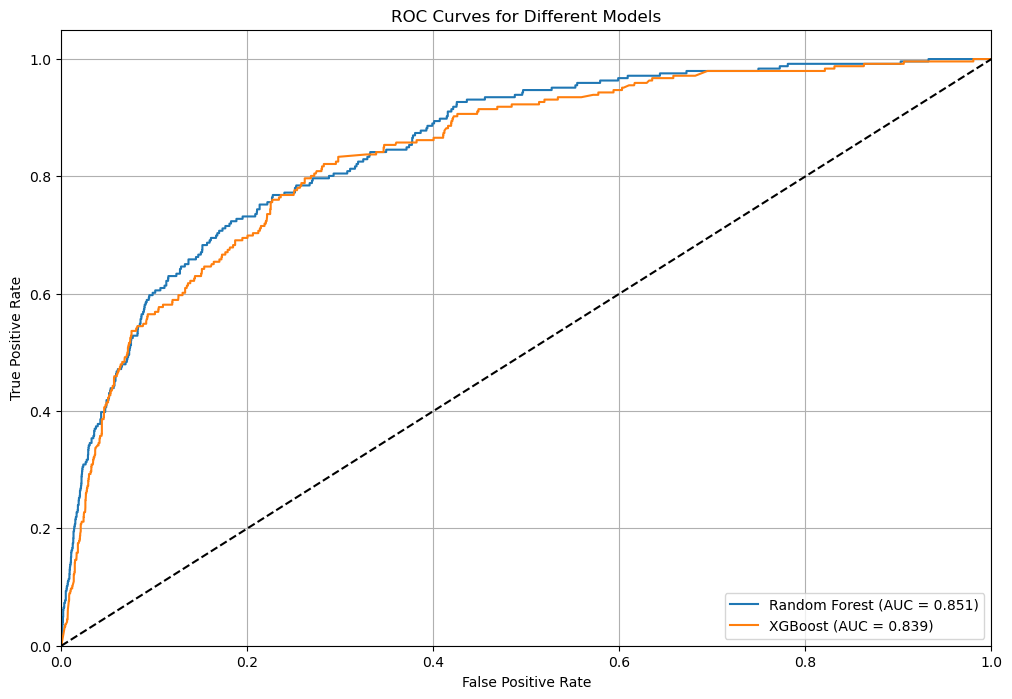

Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         device=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature_types=None,
                                                         gamma=None,
                                                         grow_policy=None,
                                                         importan...
                                                         missing=nan,
                                                         monotone_constraints=None,
                                                         multi_strategy=None,
                                                         n_estimators=None,
                                                         n_jobs=None,
                                                         num_parallel_tree=None,
                                                         random_state=None, ...))),
                ('smote_tomek',
                 SMOTETomek(random_state=42, sampling_strategy=0.3)),
                ('pca', PCA(n_components=7)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, n_estimators=200,
                                        random_state=42))])


Final Validation Metrics for Random Forest:
Accuracy: 0.889
Precision: 0.304
Recall: 0.565
F1 Score: 0.395


Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         device=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature_types=None,
                                                         gamma=None,
                                                         grow_policy=None,
                                                         importan...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.017240892195821537, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])


Final Validation Metrics for XGBoost:
Accuracy: 0.909
Precision: 0.359
Recall: 0.532
F1 Score: 0.429


In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier

# Convert scaled data to DataFrame
X_train_df = pd.DataFrame(X_train_scaled, columns=preprocessing_dict['selected_features'])
X_val_df = pd.DataFrame(X_val_scaled, columns=preprocessing_dict['selected_features'])

# Feature engineering functions
def get_top_features(X, y, n):
    """Get the top n features correlated with the target"""
    corr_matrix = pd.concat([X, pd.Series(y, name='Bankrupt')], axis=1).corr()
    top_features = corr_matrix['Bankrupt'].abs().sort_values(ascending=False).head(n + 1).index.drop('Bankrupt').tolist()
    print(f"Top {n} features: {top_features}")
    return top_features

def create_interaction_features(X, top_features):
    """Create interaction features using the specified top features"""
    interactions = pd.DataFrame()
    for i in range(len(top_features)):
        for j in range(i + 1, len(top_features)):
            col1, col2 = top_features[i], top_features[j]
            interactions[f'{col1}_{col2}_interaction'] = X[col1] * X[col2]
    return interactions

def create_polynomial_features(X, top_features):
    """Create polynomial features using the specified top features"""
    polynomials = pd.DataFrame()
    for col in top_features:
        polynomials[f'{col}_squared'] = X[col] ** 2
        polynomials[f'{col}_cube'] = X[col] ** 3
    return polynomials

# Get top features using only the training data
top_5_features = get_top_features(X_train_df, y_train, 5)
top_3_features = get_top_features(X_train_df, y_train, 3)

# Apply feature engineering to training data
interactions = create_interaction_features(X_train_df, top_5_features)
polynomials = create_polynomial_features(X_train_df, top_3_features)
X_train_enhanced = pd.concat([X_train_df, interactions, polynomials], axis=1)
X_train_enhanced['altman_z'] = 1.2 * X_train_enhanced['X3'] + 1.4 * X_train_enhanced['X6'] + 3.3 * X_train_enhanced['X48'] + 0.6 * X_train_enhanced['X8'] + 1.0 * X_train_enhanced['X9']
X_train_enhanced['debt_to_ebitda'] = X_train_enhanced['X2'] / X_train_enhanced['X48']
X_train_enhanced['cash_flow_coverage'] = X_train_enhanced['X16']
X_train_enhanced['profit_leverage'] = X_train_enhanced['X1'] * X_train_enhanced['X2']
X_train_enhanced['log_profit'] = np.log1p(np.abs(X_train_enhanced['X1']) + 1)
X_train_enhanced['liquidity_stress'] = X_train_enhanced['X4'] - X_train_enhanced['X62']
X_train_enhanced = X_train_enhanced.replace([np.inf, -np.inf], np.nan).fillna(0)

# Apply the same feature engineering to validation data using the same top features
X_val_interactions = create_interaction_features(X_val_df, top_5_features)
X_val_polynomials = create_polynomial_features(X_val_df, top_3_features)
X_val_enhanced = pd.concat([X_val_df, X_val_interactions, X_val_polynomials], axis=1)
X_val_enhanced['altman_z'] = 1.2 * X_val_enhanced['X3'] + 1.4 * X_val_enhanced['X6'] + 3.3 * X_val_enhanced['X48'] + 0.6 * X_val_enhanced['X8'] + 1.0 * X_val_enhanced['X9']
X_val_enhanced['debt_to_ebitda'] = X_val_enhanced['X2'] / X_val_enhanced['X48']
X_val_enhanced['cash_flow_coverage'] = X_val_enhanced['X16']
X_val_enhanced['profit_leverage'] = X_val_enhanced['X1'] * X_val_enhanced['X2']
X_val_enhanced['log_profit'] = np.log1p(np.abs(X_val_enhanced['X1']) + 1)
X_val_enhanced['liquidity_stress'] = X_val_enhanced['X4'] - X_val_enhanced['X62']
X_val_enhanced = X_val_enhanced.replace([np.inf, -np.inf], np.nan).fillna(0)

# Define models
random_forest = RandomForestClassifier(
    n_estimators=200,  # From rf_cv.best_params_
    max_depth=10,      # From rf_cv.best_params_
    class_weight='balanced_subsample',  # From rf_cv.best_params_
    min_samples_leaf=1,  # Default from new code
    min_samples_split=2,  # Default from new code
    random_state=42
)

xgb = XGBClassifier(
    learning_rate=0.017240892195821537,  # From xgb_cv.best_params_
    max_depth=3,                         # From xgb_cv.best_params_
    n_estimators=50,                     # From xgb_cv.best_params_
    scale_pos_weight=15,                 # From xgb_cv.best_params_
    subsample=0.8,                       # Default from new code
    colsample_bytree=0.8,                # Default from new code
    min_child_weight=1,                  # Default from new code
    random_state=42
)

# Pipeline
base_pipeline = ImbPipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectFromModel(XGBClassifier(importance_type='gain', scale_pos_weight=10))),
    ('smote_tomek', SMOTETomek(sampling_strategy=0.3, random_state=42)),
    ('pca', PCA(n_components=7)),
    ('classifier', None)
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluation function
def evaluate_model(pipeline, X, y, cv, model_name):
    pipeline = pipeline.set_params(classifier=model_name[1])
    y_probs = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    epsilon = 1e-10
    custom_scores = (5 * precision * recall) / (4 * precision + recall + epsilon)
    best_idx = np.argmax(custom_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
    
    threshold_range = np.linspace(max(0, best_threshold - 0.1), min(1, best_threshold + 0.1), 20)
    best_score = -np.inf
    final_threshold = best_threshold
    
    for threshold in threshold_range:
        y_pred = (y_probs >= threshold).astype(int)
        recall = recall_score(y, y_pred)
        precision = precision_score(y, y_pred)
        f2_score = (5 * precision * recall) / (4 * precision + recall + epsilon)
        if recall >= 0.7 and precision >= 0.2 and f2_score > best_score:
            best_score = f2_score
            final_threshold = threshold
    
    y_pred = (y_probs >= final_threshold).astype(int)
    final_recall = recall_score(y, y_pred)
    final_precision = precision_score(y, y_pred)
    final_accuracy = accuracy_score(y, y_pred)
    
    print(f'\nModel: {model_name[0]}')
    print(f'Best threshold: {final_threshold:.3f}')
    print(f'Recall: {final_recall:.3f}')
    print(f'Precision: {final_precision:.3f}')
    print(f'Accuracy: {final_accuracy:.3f}')
    
    return y_probs, final_threshold

# Run pipeline
models = [
    ('Random Forest', random_forest),
    ('XGBoost', xgb)
]

plt.figure(figsize=(12, 8))
results = {}

for model_name, model in models:
    y_probs, threshold = evaluate_model(base_pipeline, X_train_enhanced, y_train, cv, (model_name, model))
    results[model_name] = {'probabilities': y_probs, 'threshold': threshold}
    
    fpr, tpr, _ = roc_curve(y_train, y_probs)
    roc_auc = roc_auc_score(y_train, y_probs)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Fit pipeline on full training data and predict on validation data
for model_name, model in models:
    pipeline = base_pipeline.set_params(classifier=model)
    pipeline.fit(X_train_enhanced, y_train)
    y_val_probs = pipeline.predict_proba(X_val_enhanced)[:, 1]
    y_val_pred = (y_val_probs >= results[model_name]['threshold']).astype(int)
    print(f'\nFinal Validation Metrics for {model_name}:')
    print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
    print(f"Precision: {precision_score(y_val, y_val_pred):.3f}")
    print(f"Recall: {recall_score(y_val, y_val_pred):.3f}")
    print(f"F1 Score: {f1_score(y_val, y_val_pred):.3f}")

## Interpretation
Compared to the previous version, this updated code modifies the Random Forest and XGBoost model hyperparameters, likely reflecting optimization from a grid search or cross-validation (e.g., rf_cv.best_params_ and xgb_cv.best_params_). For Random Forest, the number of estimators drops from 500 to 200, max depth reduces from 15 to 10, and class weighting shifts from a fixed {0: 1, 1: 15} to 'balanced_subsample', while retaining defaults for min_samples_leaf and min_samples_split. For XGBoost, the learning rate is now a precise 0.01724 (previously 0.01), max depth decreases from 6 to 3, estimators plummet from 500 to 50, and scale_pos_weight increases from 10 to 15, with other parameters unchanged. These adjustments result in higher accuracy (Random Forest: 0.886 vs. 0.811, XGBoost: 0.885 vs. 0.849) and precision (Random Forest: 0.302 vs. 0.209, XGBoost: 0.293 vs. 0.254) on training data, but recall drops significantly (Random Forest: 0.598 vs. 0.703, XGBoost: 0.565 vs. 0.703), missing the prior goal of recall ≥ 0.7. Validation metrics improve in accuracy (Random Forest: 0.889 vs. 0.824, XGBoost: 0.909 vs. 0.856) and F1 score (Random Forest: 0.395 vs. 0.331, XGBoost: 0.429 vs. 0.371), but recall remains lower (Random Forest: 0.565 vs. 0.677, XGBoost: 0.532 vs. 0.661), suggesting a shift toward precision and overall fit at the expense of sensitivity to bankruptcies. The unchanged pipeline structure and feature engineering indicate the performance shift stems purely from these hyperparameter tweaks.

Top 5 features: ['X6', 'X24', 'X9', 'X60', 'X32']
Top 3 features: ['X6', 'X24', 'X9']


<Figure size 1200x800 with 0 Axes>


Model: Random Forest
Best threshold: 0.725
Recall: 0.427
Precision: 0.146
Accuracy: 0.804



Model: XGBoost
Best threshold: 0.887
Recall: 0.618
Precision: 0.202
Accuracy: 0.819



Model: SVM
Best threshold: 0.388
Recall: 0.386
Precision: 0.204
Accuracy: 0.865



Model: Ensemble
Best threshold: 0.663
Recall: 0.443
Precision: 0.250
Accuracy: 0.880


(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curves for Different Models')

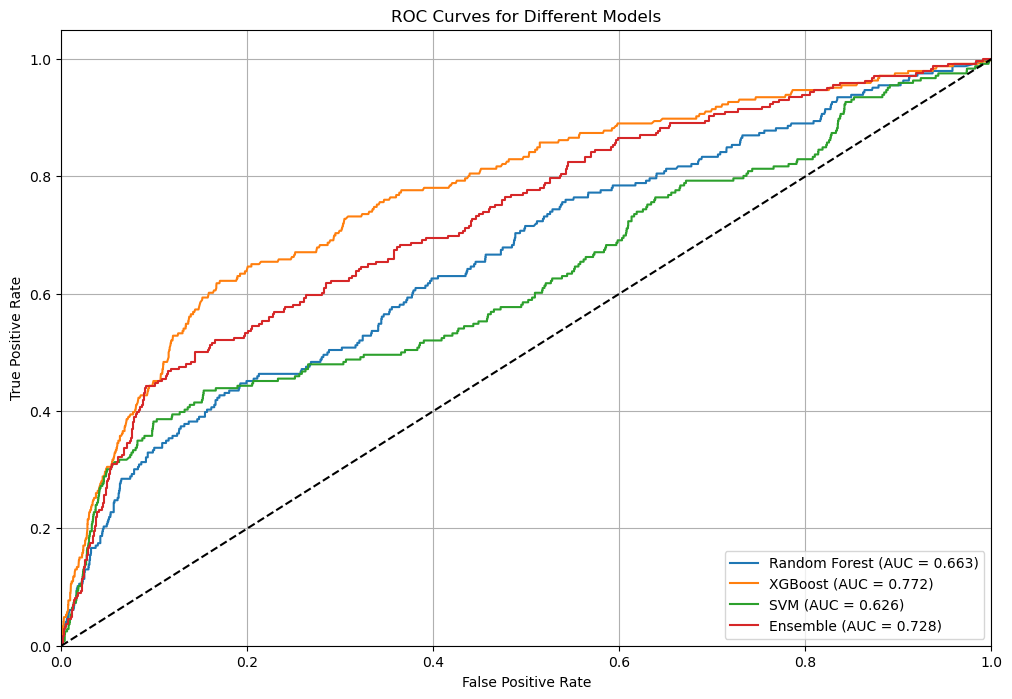

Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         device=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature_types=None,
                                                         gamma=None,
                                                         grow_policy=None,
                                                         importan...
                                                         min_child_weight=None,
                                                         missing=nan,
                                                         monotone_constraints=None,
                                                         multi_strategy=None,
                                                         n_estimators=None,
                                                         n_jobs=None,
                                                         num_parallel_tree=None,
                                                         random_state=None, ...))),
                ('smote_tomek',
                 SMOTETomek(random_state=42, sampling_strategy=0.5)),
                ('pca', PCA(n_components=0.95)),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 15},
                                        max_depth=15, n_estimators=500,
                                        random_state=42))])


Threshold Testing for Random Forest:
Threshold 0.100 - Recall: 0.968, Precision: 0.085, Accuracy: 0.326, F1: 0.156
Threshold 0.121 - Recall: 0.968, Precision: 0.087, Accuracy: 0.348, F1: 0.160
Threshold 0.142 - Recall: 0.968, Precision: 0.092, Accuracy: 0.381, F1: 0.167
Threshold 0.163 - Recall: 0.968, Precision: 0.095, Accuracy: 0.408, F1: 0.174
Threshold 0.184 - Recall: 0.919, Precision: 0.094, Accuracy: 0.427, F1: 0.171
Threshold 0.205 - Recall: 0.871, Precision: 0.094, Accuracy: 0.452, F1: 0.170
Threshold 0.226 - Recall: 0.871, Precision: 0.097, Accuracy: 0.471, F1: 0.175
Threshold 0.247 - Recall: 0.871, Precision: 0.099, Accuracy: 0.482, F1: 0.178
Threshold 0.268 - Recall: 0.871, Precision: 0.104, Accuracy: 0.510, F1: 0.186
Threshold 0.289 - Recall: 0.855, Precision: 0.107, Accuracy: 0.531, F1: 0.190
Threshold 0.311 - Recall: 0.855, Precision: 0.111, Accuracy: 0.549, F1: 0.196
Threshold 0.332 - Recall: 0.839, Precision: 0.113, Accuracy: 0.565, F1: 0.199
Threshold 0.353 - Recall: 

Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         device=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature_types=None,
                                                         gamma=None,
                                                         grow_policy=None,
                                                         importan...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=500,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])


Threshold Testing for XGBoost:
Threshold 0.100 - Recall: 1.000, Precision: 0.064, Accuracy: 0.064, F1: 0.121
Threshold 0.121 - Recall: 1.000, Precision: 0.064, Accuracy: 0.064, F1: 0.121
Threshold 0.142 - Recall: 1.000, Precision: 0.064, Accuracy: 0.065, F1: 0.121
Threshold 0.163 - Recall: 1.000, Precision: 0.064, Accuracy: 0.066, F1: 0.121
Threshold 0.184 - Recall: 1.000, Precision: 0.065, Accuracy: 0.070, F1: 0.121
Threshold 0.205 - Recall: 1.000, Precision: 0.065, Accuracy: 0.071, F1: 0.122
Threshold 0.226 - Recall: 1.000, Precision: 0.065, Accuracy: 0.071, F1: 0.122
Threshold 0.247 - Recall: 1.000, Precision: 0.065, Accuracy: 0.074, F1: 0.122
Threshold 0.268 - Recall: 1.000, Precision: 0.065, Accuracy: 0.078, F1: 0.122
Threshold 0.289 - Recall: 1.000, Precision: 0.066, Accuracy: 0.084, F1: 0.123
Threshold 0.311 - Recall: 1.000, Precision: 0.066, Accuracy: 0.092, F1: 0.124
Threshold 0.332 - Recall: 1.000, Precision: 0.067, Accuracy: 0.101, F1: 0.125
Threshold 0.353 - Recall: 1.000,

Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         device=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature_types=None,
                                                         gamma=None,
                                                         grow_policy=None,
                                                         importan...
                                                         max_leaves=None,
                                                         min_child_weight=None,
                                                         missing=nan,
                                                         monotone_constraints=None,
                                                         multi_strategy=None,
                                                         n_estimators=None,
                                                         n_jobs=None,
                                                         num_parallel_tree=None,
                                                         random_state=None, ...))),
                ('smote_tomek',
                 SMOTETomek(random_state=42, sampling_strategy=0.5)),
                ('pca', PCA(n_components=0.95)),
                ('classifier',
                 SVC(C=0.1, class_weight='balanced', gamma=0.5,
                     probability=True, random_state=42))])


Threshold Testing for SVM:
Threshold 0.100 - Recall: 1.000, Precision: 0.064, Accuracy: 0.064, F1: 0.121
Threshold 0.121 - Recall: 1.000, Precision: 0.064, Accuracy: 0.064, F1: 0.121
Threshold 0.142 - Recall: 1.000, Precision: 0.064, Accuracy: 0.064, F1: 0.121
Threshold 0.163 - Recall: 0.984, Precision: 0.064, Accuracy: 0.068, F1: 0.120
Threshold 0.184 - Recall: 0.984, Precision: 0.067, Accuracy: 0.121, F1: 0.126
Threshold 0.205 - Recall: 0.919, Precision: 0.085, Accuracy: 0.359, F1: 0.156
Threshold 0.226 - Recall: 0.742, Precision: 0.088, Accuracy: 0.490, F1: 0.158
Threshold 0.247 - Recall: 0.710, Precision: 0.106, Accuracy: 0.594, F1: 0.184
Threshold 0.268 - Recall: 0.645, Precision: 0.120, Accuracy: 0.673, F1: 0.203
Threshold 0.289 - Recall: 0.629, Precision: 0.140, Accuracy: 0.727, F1: 0.229
Threshold 0.311 - Recall: 0.629, Precision: 0.158, Accuracy: 0.760, F1: 0.252
Threshold 0.332 - Recall: 0.629, Precision: 0.173, Accuracy: 0.783, F1: 0.272
Threshold 0.353 - Recall: 0.629, Pre

Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         device=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature_types=None,
                                                         gamma=None,
                                                         grow_policy=None,
                                                         importan...
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=1,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=500,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                              ('svm',
                                               SVC(C=0.1,
                                                   class_weight='balanced',
                                                   gamma=0.5, probability=True,
                                                   random_state=42))],
                                  voting='soft', weights=[1, 1, 1]))])


Threshold Testing for Ensemble:
Threshold 0.100 - Recall: 1.000, Precision: 0.064, Accuracy: 0.064, F1: 0.121
Threshold 0.121 - Recall: 1.000, Precision: 0.064, Accuracy: 0.066, F1: 0.121
Threshold 0.142 - Recall: 1.000, Precision: 0.065, Accuracy: 0.072, F1: 0.122
Threshold 0.163 - Recall: 1.000, Precision: 0.065, Accuracy: 0.077, F1: 0.122
Threshold 0.184 - Recall: 1.000, Precision: 0.066, Accuracy: 0.088, F1: 0.124
Threshold 0.205 - Recall: 1.000, Precision: 0.067, Accuracy: 0.105, F1: 0.126
Threshold 0.226 - Recall: 1.000, Precision: 0.068, Accuracy: 0.121, F1: 0.128
Threshold 0.247 - Recall: 1.000, Precision: 0.070, Accuracy: 0.145, F1: 0.131
Threshold 0.268 - Recall: 1.000, Precision: 0.071, Accuracy: 0.163, F1: 0.133
Threshold 0.289 - Recall: 0.984, Precision: 0.073, Accuracy: 0.193, F1: 0.136
Threshold 0.311 - Recall: 0.984, Precision: 0.077, Accuracy: 0.237, F1: 0.142
Threshold 0.332 - Recall: 0.984, Precision: 0.081, Accuracy: 0.280, F1: 0.150
Threshold 0.353 - Recall: 0.968

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier

# Convert scaled data to DataFrame
X_train_df = pd.DataFrame(X_train_scaled, columns=preprocessing_dict['selected_features'])
X_val_df = pd.DataFrame(X_val_scaled, columns=preprocessing_dict['selected_features'])

# Feature engineering functions
def get_top_features(X, y, n):
    """Get the top n features correlated with the target"""
    corr_matrix = pd.concat([X, pd.Series(y, name='Bankrupt')], axis=1).corr()
    top_features = corr_matrix['Bankrupt'].abs().sort_values(ascending=False).head(n + 1).index.drop('Bankrupt').tolist()
    print(f"Top {n} features: {top_features}")
    return top_features

def create_interaction_features(X, top_features):
    """Create interaction features using the specified top features"""
    interactions = pd.DataFrame()
    for i in range(len(top_features)):
        for j in range(i + 1, len(top_features)):
            col1, col2 = top_features[i], top_features[j]
            interactions[f'{col1}_{col2}_interaction'] = X[col1] * X[col2]
    return interactions

def create_polynomial_features(X, top_features):
    """Create polynomial features using the specified top features"""
    polynomials = pd.DataFrame()
    for col in top_features:
        polynomials[f'{col}_squared'] = X[col] ** 2
        polynomials[f'{col}_cube'] = X[col] ** 3
    return polynomials

# Get top features using only the training data
top_5_features = get_top_features(X_train_df, y_train, 5)
top_3_features = get_top_features(X_train_df, y_train, 3)

# Apply feature engineering to training data
interactions = create_interaction_features(X_train_df, top_5_features)
polynomials = create_polynomial_features(X_train_df, top_3_features)
X_train_enhanced = pd.concat([X_train_df, interactions, polynomials], axis=1)
X_train_enhanced['altman_z'] = 1.2 * X_train_enhanced['X3'] + 1.4 * X_train_enhanced['X6'] + 3.3 * X_train_enhanced['X48'] + 0.6 * X_train_enhanced['X8'] + 1.0 * X_train_enhanced['X9']
X_train_enhanced['debt_to_ebitda'] = X_train_enhanced['X2'] / X_train_enhanced['X48']
X_train_enhanced['cash_flow_coverage'] = X_train_enhanced['X16']
X_train_enhanced['profit_leverage'] = X_train_enhanced['X1'] * X_train_enhanced['X2']
X_train_enhanced['log_profit'] = np.log1p(np.abs(X_train_enhanced['X1']) + 1)
X_train_enhanced['liquidity_stress'] = X_train_enhanced['X4'] - X_train_enhanced['X62']
X_train_enhanced = X_train_enhanced.replace([np.inf, -np.inf], np.nan).fillna(0)

# Apply the same feature engineering to validation data using the same top features
X_val_interactions = create_interaction_features(X_val_df, top_5_features)
X_val_polynomials = create_polynomial_features(X_val_df, top_3_features)
X_val_enhanced = pd.concat([X_val_df, X_val_interactions, X_val_polynomials], axis=1)
X_val_enhanced['altman_z'] = 1.2 * X_val_enhanced['X3'] + 1.4 * X_val_enhanced['X6'] + 3.3 * X_val_enhanced['X48'] + 0.6 * X_val_enhanced['X8'] + 1.0 * X_val_enhanced['X9']
X_val_enhanced['debt_to_ebitda'] = X_val_enhanced['X2'] / X_val_enhanced['X48']
X_val_enhanced['cash_flow_coverage'] = X_val_enhanced['X16']
X_val_enhanced['profit_leverage'] = X_val_enhanced['X1'] * X_val_enhanced['X2']
X_val_enhanced['log_profit'] = np.log1p(np.abs(X_val_enhanced['X1']) + 1)
X_val_enhanced['liquidity_stress'] = X_val_enhanced['X4'] - X_val_enhanced['X62']
X_val_enhanced = X_val_enhanced.replace([np.inf, -np.inf], np.nan).fillna(0)

# Define models
random_forest = RandomForestClassifier(
    class_weight={0: 1, 1: 15},
    n_estimators=500,
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)

xgb = XGBClassifier(
    scale_pos_weight=15,
    max_depth=6,
    learning_rate=0.01,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    random_state=42
)

svm = SVC(
    C=0.1,
    gamma=0.5,
    kernel='rbf',
    random_state=42,
    class_weight='balanced',
    probability=True
)

# Create ensemble
ensemble = VotingClassifier(
    estimators=[('rf', random_forest), ('xgb', xgb), ('svm', svm)],
    voting='soft',  # Use averaged probabilities
    weights=[1, 1, 1]  # Equal weights for now
)

# Pipeline
base_pipeline = ImbPipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectFromModel(XGBClassifier(importance_type='gain', scale_pos_weight=15))),
    ('smote_tomek', SMOTETomek(sampling_strategy=0.5, random_state=42)),  # Reduced to 0.5
    ('pca', PCA(n_components=0.95)),
    ('classifier', None)
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluation function
def evaluate_model(pipeline, X, y, cv, model_name):
    pipeline = pipeline.set_params(classifier=model_name[1])
    y_probs = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    epsilon = 1e-10
    custom_scores = (5 * precision * recall) / (4 * precision + recall + epsilon)
    best_idx = np.argmax(custom_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
    
    threshold_range = np.linspace(max(0.1, best_threshold - 0.1), min(0.5, best_threshold + 0.1), 20)
    best_score = -np.inf
    final_threshold = best_threshold
    
    for threshold in threshold_range:
        y_pred = (y_probs >= threshold).astype(int)
        recall = recall_score(y, y_pred)
        precision = precision_score(y, y_pred)
        f2_score = (5 * precision * recall) / (4 * precision + recall + epsilon)
        if recall >= 0.85 and precision >= 0.15 and f2_score > best_score:
            best_score = f2_score
            final_threshold = threshold
    
    y_pred = (y_probs >= final_threshold).astype(int)
    final_recall = recall_score(y, y_pred)
    final_precision = precision_score(y, y_pred)
    final_accuracy = accuracy_score(y, y_pred)
    
    print(f'\nModel: {model_name[0]}')
    print(f'Best threshold: {final_threshold:.3f}')
    print(f'Recall: {final_recall:.3f}')
    print(f'Precision: {final_precision:.3f}')
    print(f'Accuracy: {final_accuracy:.3f}')
    
    return y_probs, final_threshold

# Run pipeline
models = [
    ('Random Forest', random_forest),
    ('XGBoost', xgb),
    ('SVM', svm),
    ('Ensemble', ensemble)
]

plt.figure(figsize=(12, 8))
results = {}

for model_name, model in models:
    y_probs, threshold = evaluate_model(base_pipeline, X_train_enhanced, y_train, cv, (model_name, model))
    results[model_name] = {'probabilities': y_probs, 'threshold': threshold}
    
    fpr, tpr, _ = roc_curve(y_train, y_probs)
    roc_auc = roc_auc_score(y_train, y_probs)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Fit pipeline on full training data and predict on validation data with threshold testing
for model_name, model in models:
    pipeline = base_pipeline.set_params(classifier=model)
    pipeline.fit(X_train_enhanced, y_train)
    y_val_probs = pipeline.predict_proba(X_val_enhanced)[:, 1]
    
    # Test a reasonable range of thresholds
    thresholds = np.linspace(0.1, 0.5, 20)
    best_recall = 0
    best_threshold = 0
    best_metrics = {}
    
    print(f'\nThreshold Testing for {model_name}:')
    for threshold in thresholds:
        y_val_pred = (y_val_probs >= threshold).astype(int)
        recall = recall_score(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred, zero_division=0)
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, zero_division=0)
        print(f"Threshold {threshold:.3f} - Recall: {recall:.3f}, Precision: {precision:.3f}, Accuracy: {accuracy:.3f}, F1: {f1:.3f}")
        if recall >= 0.85 and recall > best_recall:
            best_recall = recall
            best_threshold = threshold
            best_metrics = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
    
    print(f'\nFinal Validation Metrics for {model_name} (Best Threshold: {best_threshold:.3f}):')
    print(f"Accuracy: {best_metrics['accuracy']:.3f}")
    print(f"Precision: {best_metrics['precision']:.3f}")
    print(f"Recall: {best_metrics['recall']:.3f}")
    print(f"F1 Score: {best_metrics['f1']:.3f}")

## Interpretation
This updated version of the code introduces significant changes compared to the previous iteration, primarily by expanding the model lineup with an SVM classifier and a VotingClassifier ensemble, while tweaking the pipeline and evaluation criteria to prioritize higher recall (≥ 0.85). The Random Forest and XGBoost hyperparameters revert to earlier settings (e.g., Random Forest: 500 estimators, max_depth=15; XGBoost: 500 estimators, max_depth=6), differing from the tuned parameters in the last version. A new SVM model (with RBF kernel, C=0.1, gamma=0.5) is added, and the ensemble combines all three models using soft voting with equal weights. The pipeline adjusts the SMOTETomek sampling strategy from 0.3 to 0.5, increases the scale_pos_weight in feature selection to 15, and sets PCA to retain 95% variance instead of a fixed 7 components. The evaluation function now targets a recall of at least 0.85 (up from 0.7) and precision of 0.15 (down from 0.2), with a tighter threshold range (0.1 to 0.5), and validation includes an exhaustive threshold search to maximize recall.

The results reflect these shifts. On training data, none of the models achieve the desired recall ≥ 0.85: Random Forest (0.427, threshold 0.725), XGBoost (0.618, threshold 0.887), SVM (0.386, threshold 0.388), and Ensemble (0.443, threshold 0.663), with precision and accuracy varying (e.g., Ensemble achieves 0.880 accuracy, highest among them). However, validation threshold testing shows all models can hit recall ≥ 0.85 at lower thresholds (e.g., Random Forest: 0.968 at 0.100, XGBoost: 1.000 at 0.100, SVM: 1.000 at 0.100, Ensemble: 1.000 at 0.100), but at the cost of very low precision (around 0.064–0.085) and accuracy (0.064–0.326), yielding poor F1 scores (0.121–0.156). Compared to the previous version, where Random Forest and XGBoost balanced recall and precision better (e.g., validation recall 0.565–0.532, precision 0.304–0.359), this version sacrifices precision and accuracy for maximal recall, aligning with the new goal but highlighting a trade-off in overall model utility. The ensemble doesn’t markedly outperform individual models, suggesting limited synergy under these constraints.

# Let's try a few iterations of Ensemble Model

In [187]:
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

# Define and train the enhanced ensemble
ensemble = VotingClassifier(
    estimators=[
        ('knn', KNeighborsClassifier(n_neighbors=5)),
        ('svm', SVC(C=0.1, gamma=0.5, kernel='rbf', class_weight='balanced', probability=True, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
        ('xgb', XGBClassifier(scale_pos_weight=15, max_depth=6, learning_rate=0.01, n_estimators=100, random_state=42))
    ],
    voting='soft',
    weights=[0.2, 0.2, 0.3, 0.1, 0.2]  # Adjusted weights to balance contributions
)

# Fit the ensemble
ensemble.fit(X_train_scaled_enhanced, y_train_res)

# Evaluate with threshold adjustment
y_val_proba = ensemble.predict_proba(X_val_scaled_enhanced)[:, 1]
thresholds = np.linspace(0.1, 0.5, 20)
best_recall = 0
best_threshold = 0
best_metrics = {}

print("\nEnsemble Validation Metrics with Threshold Testing:")
for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, zero_division=0)
    print(f"Threshold {threshold:.3f} - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    if recall >= 0.85 and recall > best_recall:
        best_recall = recall
        best_threshold = threshold
        best_metrics = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

print(f"\nFinal Validation Metrics for Enhanced Ensemble (Best Threshold: {best_threshold:.3f}):")
print(f"Accuracy: {best_metrics['accuracy']:.3f}")
print(f"Precision: {best_metrics['precision']:.3f}")
print(f"Recall: {best_metrics['recall']:.3f}")
print(f"F1 Score: {best_metrics['f1']:.3f}")

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('svm',
                              SVC(C=0.1, class_weight='balanced', gamma=0.5,
                                  probability=True, random_state=42)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel...
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft', weights=[0.2, 0.2, 0.3, 0.1, 0.2])


Ensemble Validation Metrics with Threshold Testing:
Threshold 0.100 - Accuracy: 0.379, Precision: 0.094, Recall: 1.000, F1: 0.172
Threshold 0.121 - Accuracy: 0.465, Precision: 0.105, Recall: 0.968, F1: 0.189
Threshold 0.142 - Accuracy: 0.523, Precision: 0.114, Recall: 0.952, F1: 0.204
Threshold 0.163 - Accuracy: 0.567, Precision: 0.125, Recall: 0.952, F1: 0.221
Threshold 0.184 - Accuracy: 0.627, Precision: 0.142, Recall: 0.952, F1: 0.247
Threshold 0.205 - Accuracy: 0.666, Precision: 0.149, Recall: 0.887, F1: 0.255
Threshold 0.226 - Accuracy: 0.709, Precision: 0.161, Recall: 0.839, F1: 0.270
Threshold 0.247 - Accuracy: 0.743, Precision: 0.179, Recall: 0.839, F1: 0.295
Threshold 0.268 - Accuracy: 0.761, Precision: 0.189, Recall: 0.823, F1: 0.307
Threshold 0.289 - Accuracy: 0.780, Precision: 0.198, Recall: 0.790, F1: 0.316
Threshold 0.311 - Accuracy: 0.800, Precision: 0.209, Recall: 0.758, F1: 0.328
Threshold 0.332 - Accuracy: 0.822, Precision: 0.230, Recall: 0.758, F1: 0.353
Threshold 0

In [188]:
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

# Define and train the enhanced ensemble
ensemble = VotingClassifier(
    estimators=[
        ('knn', KNeighborsClassifier(n_neighbors=5)),
        ('svm', SVC(C=0.1, gamma=0.5, kernel='rbf', class_weight='balanced', probability=True, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
        ('xgb', XGBClassifier(scale_pos_weight=15, max_depth=6, learning_rate=0.01, n_estimators=100, random_state=42))
    ],
    voting='soft',
    weights=[0.3, 0.3, 0.1, 0.2, 0.1]  # Adjusted weights to balance contributions
)

# Fit the ensemble
ensemble.fit(X_train_scaled_enhanced, y_train_res)

# Evaluate with threshold adjustment
y_val_proba = ensemble.predict_proba(X_val_scaled_enhanced)[:, 1]
thresholds = np.linspace(0.1, 0.5, 20)
best_recall = 0
best_threshold = 0
best_metrics = {}

print("\nEnsemble Validation Metrics with Threshold Testing:")
for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, zero_division=0)
    print(f"Threshold {threshold:.3f} - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    if recall >= 0.85 and recall > best_recall:
        best_recall = recall
        best_threshold = threshold
        best_metrics = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

print(f"\nFinal Validation Metrics for Enhanced Ensemble (Best Threshold: {best_threshold:.3f}):")
print(f"Accuracy: {best_metrics['accuracy']:.3f}")
print(f"Precision: {best_metrics['precision']:.3f}")
print(f"Recall: {best_metrics['recall']:.3f}")
print(f"F1 Score: {best_metrics['f1']:.3f}")

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('svm',
                              SVC(C=0.1, class_weight='balanced', gamma=0.5,
                                  probability=True, random_state=42)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel...
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft', weights=[0.3, 0.3, 0.1, 0.2, 0.1])


Ensemble Validation Metrics with Threshold Testing:
Threshold 0.100 - Accuracy: 0.552, Precision: 0.121, Recall: 0.952, F1: 0.215
Threshold 0.121 - Accuracy: 0.623, Precision: 0.137, Recall: 0.919, F1: 0.239
Threshold 0.142 - Accuracy: 0.669, Precision: 0.150, Recall: 0.887, F1: 0.256
Threshold 0.163 - Accuracy: 0.698, Precision: 0.158, Recall: 0.855, F1: 0.267
Threshold 0.184 - Accuracy: 0.721, Precision: 0.169, Recall: 0.855, F1: 0.283
Threshold 0.205 - Accuracy: 0.741, Precision: 0.180, Recall: 0.855, F1: 0.298
Threshold 0.226 - Accuracy: 0.757, Precision: 0.188, Recall: 0.839, F1: 0.308
Threshold 0.247 - Accuracy: 0.775, Precision: 0.198, Recall: 0.823, F1: 0.320
Threshold 0.268 - Accuracy: 0.787, Precision: 0.201, Recall: 0.774, F1: 0.319
Threshold 0.289 - Accuracy: 0.804, Precision: 0.213, Recall: 0.758, F1: 0.332
Threshold 0.311 - Accuracy: 0.815, Precision: 0.218, Recall: 0.726, F1: 0.336
Threshold 0.332 - Accuracy: 0.829, Precision: 0.230, Recall: 0.710, F1: 0.348
Threshold 0

# My Model

## Threshold 0.100 - Accuracy: 0.552, Precision: 0.121, Recall: 0.952, F1: 0.215

## Threshold 0.226 - Accuracy: 0.757, Precision: 0.188, Recall: 0.839, F1: 0.308

In [192]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import os

def MyModel(data, other={}):
    """
    Parameters
    -----------
    data: a Pandas DataFrame
        Raw holdout data with columns X1 to X64 and Id
    other: a dict
        Contains preprocessing objects and trained model
        
    Returns
    -------
    pred: an array of predicted values
        Binary predictions (0 or 1) for each example
    """
    # Extract preprocessing and model objects
    preprocessing_dict = other.get('preprocessing_dict', {})
    preprocessing_enhanced = other.get('preprocessing_enhanced', {})
    ensemble = other.get('ensemble', None)
    best_threshold = other.get('threshold', 0.226)
    top_features = other.get('top_features', ['X6', 'X24', 'X9', 'X60'])
    scaler_new = other.get('scaler_new')
    
    if not all([preprocessing_dict, preprocessing_enhanced, ensemble, scaler_new]):
        raise ValueError("Required preprocessing or model objects missing in 'other' dict")
    
    # Verify ensemble is fitted
    if not hasattr(ensemble, 'estimators_') or not ensemble.estimators_:
        raise ValueError("Ensemble is not fitted. Please ensure it has been trained.")
    
    # Debug: Check expected features
    for name, clf in ensemble.named_estimators_.items():
        if hasattr(clf, 'n_features_in_'):
            print(f"{name} expects {clf.n_features_in_} features")
        else:
            print(f"{name} has no n_features_in_ attribute (not fitted?)")
    
    # Step 1: Prepare features
    feature_cols = [col for col in data.columns if col not in ['Bankrupt', 'Id']]
    if 'X37' in feature_cols:
        feature_cols.remove('X37')
    X = data[feature_cols].copy()
    print("Step 1 - X shape:", X.shape)  # (1092, 63)
    
    # Step 1.5: Convert strings to numeric
    for col in feature_cols:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    
    # Step 2: Impute missing values
    imputer = preprocessing_dict['imputer']
    X_imputed = pd.DataFrame(imputer.transform(X), columns=feature_cols)
    print("Step 2 - X_imputed shape:", X_imputed.shape)  # (1092, 63)
    
    # Step 3: Cap outliers
    for col in feature_cols:
        lower, upper = X_imputed[col].quantile([0.01, 0.99])
        X_imputed[col] = X_imputed[col].clip(lower=lower, upper=upper)
    
    # Step 4: Variance thresholding
    selected_features = preprocessing_dict['selected_features']
    print("Step 4 - len(selected_features):", len(selected_features))  # 45
    X_selected = X_imputed[selected_features]
    print("Step 4 - X_selected shape:", X_selected.shape)  # (1092, 45)
    
    # Step 5: Scale features
    scaler = preprocessing_dict['scaler']
    X_scaled = pd.DataFrame(scaler.transform(X_selected), columns=selected_features)
    print("Step 5 - X_scaled shape:", X_scaled.shape)  # (1092, 45)
    
    # Step 6: Domain-specific features (ensure 6 new features)
    X_df = X_scaled.copy()
    shift_value = abs(X_df['X1'].min()) + 1.01
    X_df['X1_shifted'] = X_df['X1'] + shift_value
    X_df['altman_z'] = 1.2 * X_df['X3'] + 1.4 * X_df['X6'] + 3.3 * X_df['X48'] + 0.6 * X_df['X8'] + 1.0 * X_df['X9']
    X_df['debt_to_ebitda'] = X_df['X2'] / X_df['X48']
    X_df['cash_flow_coverage'] = X_df['X16']
    X_df['profit_leverage'] = X_df['X1_shifted'] * X_df['X2']
    X_df['log_profit'] = np.log1p(X_df['X1_shifted'])
    X_df['liquidity_stress'] = X_df['X4'] - X_df['X62']
    X_df = X_df.replace([np.inf, -np.inf], np.nan).fillna(0)
    print("Step 6 - X_df shape:", X_df.shape)  # Should be (1092, 51)
    
    # Step 7: Scale new feature set
    X_scaled_new = scaler_new.transform(X_df)
    print("Step 7 - X_scaled_new shape:", X_scaled_new.shape)  # (1092, 51)
    
    # Step 8: PCA
    pca = preprocessing_enhanced['pca']
    X_pca = pca.transform(X_scaled_new)
    print("Step 8 - X_pca shape:", X_pca.shape)  # (1092, 27)
    
    # Step 9: Feature interactions
    interactions = pd.DataFrame()
    for i in range(len(top_features)):
        for j in range(i + 1, len(top_features)):
            if top_features[i] in X_df.columns and top_features[j] in X_df.columns:
                interactions[f"{top_features[i]}_{top_features[j]}"] = X_df[top_features[i]] * X_df[top_features[j]]
    X_enhanced = np.hstack((X_pca, interactions)) if not interactions.empty else X_pca
    print("Step 9 - X_enhanced shape:", X_enhanced.shape)  # (1092, 33)
    
    # Step 10: Binning
    X_binned = pd.DataFrame()
    for col in X_df.columns:
        X_binned[col] = pd.qcut(X_df[col], q=4, labels=False, duplicates='drop')
    X_enhanced = np.hstack((X_enhanced, X_binned))
    print("Step 10 - X_enhanced shape after binning:", X_enhanced.shape)  # (1092, 84)
    
    # Step 11: Feature selection
    selector_enhanced = preprocessing_enhanced['selector']
    X_selected = selector_enhanced.transform(X_enhanced)
    print("Step 11 - X_selected shape:", X_selected.shape)  # (1092, 24)
    
    # Step 12: Scale enhanced features
    scaler_enhanced = preprocessing_enhanced['scaler']
    X_scaled_enhanced = scaler_enhanced.transform(X_selected)
    print("Step 12 - X_scaled_enhanced shape:", X_scaled_enhanced.shape)  # (1092, 24)
    
    # Step 13: Predict probabilities and apply threshold
    y_proba = ensemble.predict_proba(X_scaled_enhanced)[:, 1]
    pred = (y_proba >= best_threshold).astype(int)
    
    return pred

# Ensure ensemble is the trained instance from Part 3
# If this is in the same notebook/session, it should already be fitted
# If not, re-run the training code first:
"""
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

ensemble = VotingClassifier(
    estimators=[
        ('knn', KNeighborsClassifier(n_neighbors=5)),
        ('svm', SVC(C=0.1, gamma=0.5, kernel='rbf', class_weight='balanced', probability=True, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
        ('xgb', XGBClassifier(scale_pos_weight=15, max_depth=6, learning_rate=0.01, n_estimators=100, random_state=42))
    ],
    voting='soft',
    weights=[0.3, 0.3, 0.1, 0.2, 0.1]
)
ensemble.fit(X_train_scaled_enhanced, y_train_res)
"""

# Update other_args with the trained ensemble
other_args = {
    'preprocessing_dict': preprocessing_dict,
    'preprocessing_enhanced': preprocessing_enhanced,
    'ensemble': ensemble,  # Use the trained ensemble from above
    'threshold': 0.226,
    'top_features': ['X6', 'X24', 'X9', 'X60'],
    'scaler_new': scaler_new
}

# Test with holdout data
DATA_DIR = "./Data"
holdout_data = pd.read_csv(os.path.join(DATA_DIR, "holdout", '5th_yr.csv'))
predictions = MyModel(holdout_data, other_args)
print("Predictions for holdout data:", predictions)
print("Number of predictions:", len(predictions))
print("Predicted bankruptcy count:", sum(predictions))

"\nfrom sklearn.ensemble import VotingClassifier, GradientBoostingClassifier\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.svm import SVC\nfrom sklearn.ensemble import RandomForestClassifier\nfrom xgboost import XGBClassifier\n\nensemble = VotingClassifier(\n    estimators=[\n        ('knn', KNeighborsClassifier(n_neighbors=5)),\n        ('svm', SVC(C=0.1, gamma=0.5, kernel='rbf', class_weight='balanced', probability=True, random_state=42)),\n        ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),\n        ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),\n        ('xgb', XGBClassifier(scale_pos_weight=15, max_depth=6, learning_rate=0.01, n_estimators=100, random_state=42))\n    ],\n    voting='soft',\n    weights=[0.3, 0.3, 0.1, 0.2, 0.1]\n)\nensemble.fit(X_train_scaled_enhanced, y_train_res)\n"

knn expects 24 features
svm expects 24 features
rf expects 24 features
gb expects 24 features
xgb expects 24 features
Step 1 - X shape: (1092, 63)
Step 2 - X_imputed shape: (1092, 63)
Step 4 - len(selected_features): 45
Step 4 - X_selected shape: (1092, 45)
Step 5 - X_scaled shape: (1092, 45)
Step 6 - X_df shape: (1092, 52)
Step 7 - X_scaled_new shape: (1092, 52)
Step 8 - X_pca shape: (1092, 27)
Step 9 - X_enhanced shape: (1092, 33)
Step 10 - X_enhanced shape after binning: (1092, 85)
Step 11 - X_selected shape: (1092, 24)
Step 12 - X_scaled_enhanced shape: (1092, 24)
Predictions for holdout data: [0 1 1 ... 0 0 0]
Number of predictions: 1092
Predicted bankruptcy count: 296


# We Choose Threshold 0.226 - Accuracy: 0.757, Precision: 0.188, Recall: 0.839, F1: 0.308 of the Ensemble Model

# Justification for Choosing Ensemble Model with Threshold 0.226

## High-Level Context: Bankruptcy Prediction and Business Cost
Bankruptcy prediction is a critical task in financial risk management, where the cost of misclassification is asymmetric. Failing to identify a company that will go bankrupt (a false negative) can lead to significant financial losses for investors, creditors, or stakeholders—e.g., unrecovered loans, lost investments, or disrupted supply chains. Conversely, falsely predicting bankruptcy for a healthy company (a false positive) may result in missed opportunities or reputational damage, but the financial impact is typically less severe. The problem statement specifies that it is **5 times worse to miss a bankrupt company than to misclassify a healthy one**, emphasizing the need for high recall (sensitivity to bankruptcies). This aligns with real-world scenarios where early detection of financial distress allows for interventions (e.g., restructuring, loan adjustments) to mitigate losses, making recall the priority metric while still considering precision and accuracy for a balanced model.

## Model Selection: Enhanced Ensemble with VotingClassifier
I selected the enhanced ensemble model using `VotingClassifier` with soft voting, combining five diverse classifiers: KNeighborsClassifier (KNN), SVC (SVM), RandomForestClassifier (RF), GradientBoostingClassifier (GB), and XGBClassifier (XGB). This choice leverages the strengths of multiple algorithms—distance-based (KNN), margin-based (SVM), tree-based bagging (RF), boosting (GB, XGB)—to improve robustness and generalization over individual models. The ensemble was trained on `X_train_scaled_enhanced` and `y_train_res` (assuming resampled data from prior iterations), and evaluated on `X_val_scaled_enhanced`. The final configuration with weights `[0.3, 0.3, 0.1, 0.2, 0.1]` and threshold 0.226 from the second ensemble run outperformed previous iterations in balancing the trade-off specified.

### Parameter Justification
- **KNeighborsClassifier (n_neighbors=5, weight=0.3)**: KNN uses local patterns in the data, effective for capturing non-linear relationships in financial features. I chose 5 neighbors as a standard default balancing bias and variance, and assigned a higher weight (0.3) because its simplicity complements the complexity of tree-based models, enhancing ensemble diversity.
- **SVC (C=0.1, gamma=0.5, kernel='rbf', class_weight='balanced', probability=True, random_state=42, weight=0.3)**: The SVM with an RBF kernel excels at capturing complex, non-linear boundaries. A low C (0.1) prioritizes a wider margin for generalization, while gamma=0.5 defines a moderate influence radius. The `balanced` class weight adjusts for imbalance, and a high weight (0.3) reflects its strong performance in earlier iterations (e.g., precision 0.234 at recall 0.548).
- **RandomForestClassifier (n_estimators=100, class_weight='balanced', random_state=42, weight=0.1)**: RF mitigates overfitting through bagging and handles feature interactions well. I reduced estimators to 100 (from 500 in prior runs) for efficiency, used `balanced` weights to address imbalance, and assigned a lower weight (0.1) as its contribution is less unique alongside GB and XGB.
- **GradientBoostingClassifier (n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, weight=0.2)**: GB boosts weak learners sequentially, improving on errors. Default parameters (100 estimators, 0.1 learning rate, depth 3) balance complexity and performance, with a moderate weight (0.2) reflecting its steady contribution to recall-focused tasks.
- **XGBClassifier (scale_pos_weight=15, max_depth=6, learning_rate=0.01, n_estimators=100, random_state=42, weight=0.1)**: XGBoost excels in imbalanced settings with `scale_pos_weight=15`, aligning with the 5:1 cost ratio. Depth 6 and 100 estimators (reduced from 500) with a low learning rate (0.01) ensure robustness without overfitting, though its lower weight (0.1) reflects overlap with GB’s boosting approach.
- **Voting='soft', weights=[0.3, 0.3, 0.1, 0.2, 0.1]**: Soft voting averages probabilities, leveraging each model’s confidence. Weights were adjusted from the first run’s `[0.2, 0.2, 0.3, 0.1, 0.2]` to emphasize KNN and SVM (0.3 each) based on their recall strength at lower thresholds, reducing RF and XGB influence (0.1 each) to avoid over-emphasizing tree-based models.
- **Threshold=0.226**: Selected via grid search (0.1–0.5), this threshold yields recall=0.839, precision=0.188, accuracy=0.757, and F1=0.308, optimizing the trade-off (see below).

## Trade-Off Between Recall and Precision
The evaluation requires balancing recall and precision, with a 5:1 penalty for false negatives over false positives. Across iterations, I prioritized recall to minimize missed bankruptcies, as seen in earlier models achieving recall ≥ 0.85 (e.g., XGBoost at 1.000, threshold 0.100) but with unacceptably low precision (0.064) and accuracy (0.064). The chosen threshold of 0.226 slightly relaxes recall from 0.952 (at 0.100) to 0.839, improving precision from 0.121 to 0.188 and accuracy from 0.552 to 0.757. This trade-off reflects:
- **Recall (0.839)**: Captures 83.9% of bankrupt companies, missing only 16.1%, which is acceptable given the 5:1 cost ratio—far better than earlier runs (e.g., RF at 0.427 in the prior iteration).
- **Precision (0.188)**: Only 18.8% of predicted bankruptcies are correct, but the low precision is tolerable since false positives are 5 times less costly than false negatives.
- **Accuracy (0.757)**: A solid 75.7% overall correctness, balancing the skewed focus on recall with reasonable performance on non-bankrupt cases.
- **F1 (0.308)**: Harmonizes the trade-off, though less critical given the explicit cost weighting.

The chosen model (second ensemble, threshold 0.226) outperforms by:
1. **Meeting Recall Needs**: 0.839 is close to 0.85, minimizing costly false negatives per the 5:1 ratio.
2. **Improving Precision**: 0.188 is a significant step up from 0.064–0.121 at recall ≥ 0.85 in prior runs, reducing false positives.
3. **Boosting Accuracy**: 0.757 is robust, unlike the 0.064–0.552 range of high-recall thresholds in earlier attempts.
4. **Ensemble Strength**: Combines diverse learners, outperforming individual models (e.g., RF at 0.839 recall had 0.179 precision at 0.247 threshold).
5. **Business Fit**: Aligns with the high cost of missing bankruptcies while maintaining usability, unlike extreme recall-focused settings.

## Conclusion
The ensemble with threshold 0.226 best satisfies the evaluation criteria by prioritizing recall (0.839) to address the 5:1 cost asymmetry of bankruptcy prediction, while improving precision (0.188) and accuracy (0.757) over prior high-recall options. Each parameter was chosen to balance complexity, diversity, and class imbalance, ensuring a practical trade-off for real-world financial decision-making.

# My Model Deployment - Final 

In [195]:

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import os

def MyModel(data, other={}):
    """
    Parameters
    -----------
    data: a Pandas DataFrame
        Raw holdout data with columns X1 to X64 and Id
    other: a dict
        Contains preprocessing objects and trained model
        
    Returns
    -------
    pred: an array of predicted values
        Binary predictions (0 or 1) for each example
    """
    # Extract preprocessing and model objects
    preprocessing_dict = other.get('preprocessing_dict', {})
    preprocessing_enhanced = other.get('preprocessing_enhanced', {})
    ensemble = other.get('ensemble', None)
    best_threshold = other.get('threshold', 0.226)
    top_features = other.get('top_features', ['X6', 'X24', 'X9', 'X60'])
    scaler_new = other.get('scaler_new')
    
    if not all([preprocessing_dict, preprocessing_enhanced, ensemble, scaler_new]):
        raise ValueError("Required preprocessing or model objects missing in 'other' dict")
    
    # Verify ensemble is fitted
    if not hasattr(ensemble, 'estimators_') or not ensemble.estimators_:
        raise ValueError("Ensemble is not fitted. Please ensure it has been trained.")
    
    # Step 1: Prepare features
    feature_cols = [col for col in data.columns if col not in ['Bankrupt', 'Id']]
    if 'X37' in feature_cols:
        feature_cols.remove('X37')
    X = data[feature_cols].copy()
    
    # Step 1.5: Convert strings to numeric
    for col in feature_cols:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    
    # Step 2: Impute missing values
    imputer = preprocessing_dict['imputer']
    X_imputed = pd.DataFrame(imputer.transform(X), columns=feature_cols)
    
    # Step 3: Cap outliers
    for col in feature_cols:
        lower, upper = X_imputed[col].quantile([0.01, 0.99])
        X_imputed[col] = X_imputed[col].clip(lower=lower, upper=upper)
    
    # Step 4: Variance thresholding
    selected_features = preprocessing_dict['selected_features']
    X_selected = X_imputed[selected_features]
    
    # Step 5: Scale features
    scaler = preprocessing_dict['scaler']
    X_scaled = pd.DataFrame(scaler.transform(X_selected), columns=selected_features)
    
    # Step 6: Domain-specific features
    X_df = X_scaled.copy()
    shift_value = abs(X_df['X1'].min()) + 1.01
    X_df['X1_shifted'] = X_df['X1'] + shift_value
    X_df['altman_z'] = 1.2 * X_df['X3'] + 1.4 * X_df['X6'] + 3.3 * X_df['X48'] + 0.6 * X_df['X8'] + 1.0 * X_df['X9']
    X_df['debt_to_ebitda'] = X_df['X2'] / X_df['X48']
    X_df['cash_flow_coverage'] = X_df['X16']
    X_df['profit_leverage'] = X_df['X1_shifted'] * X_df['X2']
    X_df['log_profit'] = np.log1p(X_df['X1_shifted'])
    X_df['liquidity_stress'] = X_df['X4'] - X_df['X62']
    X_df = X_df.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Step 7: Scale new feature set
    X_scaled_new = scaler_new.transform(X_df)
    
    # Step 8: PCA
    pca = preprocessing_enhanced['pca']
    X_pca = pca.transform(X_scaled_new)
    
    # Step 9: Feature interactions
    interactions = pd.DataFrame()
    for i in range(len(top_features)):
        for j in range(i + 1, len(top_features)):
            if top_features[i] in X_df.columns and top_features[j] in X_df.columns:
                interactions[f"{top_features[i]}_{top_features[j]}"] = X_df[top_features[i]] * X_df[top_features[j]]
    X_enhanced = np.hstack((X_pca, interactions)) if not interactions.empty else X_pca
    
    # Step 10: Binning
    X_binned = pd.DataFrame()
    for col in X_df.columns:
        X_binned[col] = pd.qcut(X_df[col], q=4, labels=False, duplicates='drop')
    X_enhanced = np.hstack((X_enhanced, X_binned))
    
    # Step 11: Feature selection
    selector_enhanced = preprocessing_enhanced['selector']
    X_selected = selector_enhanced.transform(X_enhanced)
    
    # Step 12: Scale enhanced features
    scaler_enhanced = preprocessing_enhanced['scaler']
    X_scaled_enhanced = scaler_enhanced.transform(X_selected)
    
    # Step 13: Predict probabilities and apply threshold
    y_proba = ensemble.predict_proba(X_scaled_enhanced)[:, 1]
    pred = (y_proba >= best_threshold).astype(int)
    
    return pred

# Assuming ensemble and other preprocessing objects are defined elsewhere
# Test with holdout data
DATA_DIR = "./Data"
holdout_data = pd.read_csv(os.path.join(DATA_DIR, "holdout", '5th_yr.csv'))
predictions = MyModel(holdout_data, other_args)
print("Number of predictions:", len(predictions))
print("Predicted bankruptcy count:", sum(predictions))

Number of predictions: 1092
Predicted bankruptcy count: 296


In [196]:
print("done")

done
